In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

%load_ext autoreload
%autoreload 2

In [2]:
with open("data/pkl_files/trimmed_inputs.pkl", "rb") as fp:
    old_inputs = pickle.load(fp)
with open("data/pkl_files/trimmed_outputs.pkl", "rb") as fp:
    old_outputs = pickle.load(fp)
with open("data/pkl_files/new_inputs.pkl", "rb") as fp:
    augmented_inputs = pickle.load(fp)
with open("data/pkl_files/new_outputs.pkl", "rb") as fp:
    augmented_outputs = pickle.load(fp)

In [3]:
# Sanity check
print(old_inputs.shape)
print(old_outputs.shape)
print(augmented_inputs.shape)
print(augmented_outputs.shape)

(25650, 4, 32, 32)
(25650, 1, 32, 32)
(153900, 4, 32, 32)
(153900, 1, 32, 32)


In [4]:
inputs = old_inputs
outputs = old_outputs

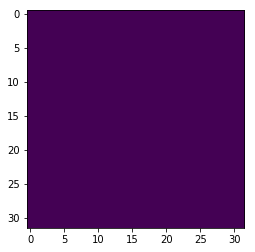

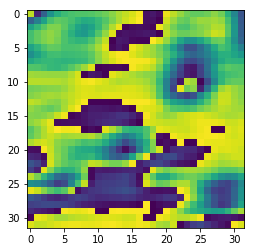

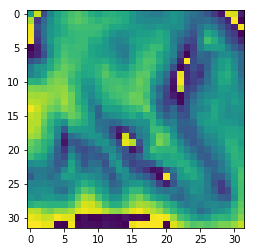

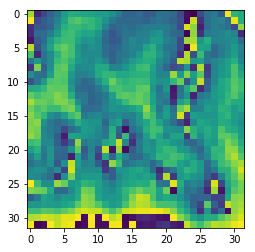

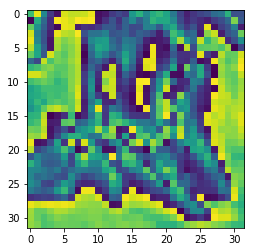

In [5]:
# Sanity Check
idx = np.random.randint(0, inputs.shape[0])
def plot_sampled_images(idx):    
    cropped_seg_img = outputs[idx,0,:,:]
    plt.imshow(cropped_seg_img)
    plt.show()
    cropped_flair_img = inputs[idx,0,:,:]
    plt.imshow(cropped_flair_img)
    plt.show()
    cropped_t1_img = inputs[idx,1,:,:]
    plt.imshow(cropped_t1_img)
    plt.show()
    cropped_t1ce_img = inputs[idx,2,:,:]
    plt.imshow(cropped_t1ce_img)
    plt.show()
    cropped_t2_img = inputs[idx,3,:,:]
    plt.imshow(cropped_t2_img)
    plt.show()
plot_sampled_images(idx)

In [6]:
np.random.seed(0)
shuffled_idxs = list(range(inputs.shape[0]))
np.random.shuffle(shuffled_idxs)
train_cutoff = int(inputs.shape[0]*75/100)
val_cutoff = int(inputs.shape[0]*95/100)

train_inputs = []
train_outputs = []
val_inputs = []
val_outputs = []
test_inputs = []
test_outputs = []

for iteration, idx in enumerate(shuffled_idxs):
    if iteration < train_cutoff:
        train_inputs.append(inputs[idx])
        train_outputs.append(outputs[idx])
    elif iteration < val_cutoff:
        val_inputs.append(inputs[idx])
        val_outputs.append(outputs[idx])
    else:
        test_inputs.append(inputs[idx])
        test_outputs.append(outputs[idx])

In [7]:
# sanity check
print(len(train_inputs))
print(len(train_outputs))
print(len(val_inputs))
print(len(val_outputs))
print(len(test_inputs))
print(len(test_outputs))

19237
19237
5130
5130
1283
1283


In [8]:
train_inputs = np.asarray(train_inputs)
val_inputs = np.asarray(val_inputs)
test_inputs = np.asarray(test_inputs)

train_inputs_mean = np.mean(train_inputs, axis=0)
train_inputs_std = np.std(train_inputs, axis=0)

train_inputs -= train_inputs_mean
train_inputs /= train_inputs_std
val_inputs -= train_inputs_mean
val_inputs /= train_inputs_std
test_inputs -= train_inputs_mean
test_inputs /= train_inputs_std

In [9]:
train_outputs = np.asarray(train_outputs)
n_tumor_pixels = np.count_nonzero(train_outputs)
n_tumor1 = np.count_nonzero(train_outputs==1)
n_tumor2 = np.count_nonzero(train_outputs==2)
n_tumor3 = np.count_nonzero(train_outputs==3)
n_tumor4 = np.count_nonzero(train_outputs==4)
total_pixels = train_outputs.shape[0]*train_outputs.shape[2]*train_outputs.shape[3]
print(total_pixels)
n_blank_pixels = total_pixels - n_tumor_pixels
frac_tumor = n_tumor_pixels/total_pixels
print(frac_tumor)

19698688
0.06718163158886521


In [10]:
train_data = []
val_data = []
test_data = []

for idx in range(train_inputs.shape[0]):
    train_data.append([train_inputs[idx], train_outputs[idx]])
for idx in range(val_inputs.shape[0]):
    val_data.append([val_inputs[idx], val_outputs[idx]])
for idx in range(test_inputs.shape[0]):
    test_data.append([test_inputs[idx], test_outputs[idx]])

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=64)

print(len(train_loader))
print(len(train_data))

301
19237


In [12]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [13]:
from models.unet import *

In [14]:
def test_UNet():
    channels_in = 4
    n_classes = 5
    x = torch.zeros((64, 4, 32, 32), dtype=dtype)
    model = UNet(channels_in, n_classes)
    scores = model(x)
    print(scores.size())
test_UNet()

torch.Size([64, 5, 32, 32])


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [15]:
# Defining all parameters 
print_every = 25
learning_rate = 1e-1
input_channels = 4
n_classes = 5
model = UNet(channel_in=input_channels, classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, lr_decay=learning_rate/float(250), weight_decay=1e-5, initial_accumulator_value=0)
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, n_blank_pixel/float(n_tumor_pixels)]).cuda()) 
class_weights = [1.0, n_blank_pixels/float(n_tumor1), n_blank_pixels/float(n_tumor2), 1.0, n_blank_pixels/float(n_tumor4)]
print(class_weights)
criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).cuda()) 

if USE_GPU and torch.cuda.is_available():
    model.cuda()
    print("did this")

[1.0, 55.02574714020483, 24.78145204141908, 1.0, 74.10709158076433]
did this


In [16]:
def create_masks(x):
    mask = np.zeros((n_classes, x.shape[0], x.shape[1]))
    for c in range(n_classes):
        mask[c] = x == c
    return mask

In [17]:
def compute_iou(scores, output):  
    scores = scores.astype(np.bool)
    output = output.astype(np.bool)
    overlap = scores*output
    union = scores+output # Logical OR
    IOU = (overlap.sum())/(float(union.sum())+1e-10) 
    return IOU

In [18]:
def iou_metric(preds, labels):
    # preds and labels are of size (64, 32, 32)
    # return average iou value for each class
    numpy_preds = preds.cpu().numpy()  
    numpy_labels = labels.cpu().numpy()
    
    iou_tracker = np.zeros((numpy_preds.shape[0], n_classes))
    # get the masks
    for idx in range(numpy_preds.shape[0]):
        """plt.title('Segmented Output')
        plt.imshow(numpy_preds[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_labels[idx,:,:])
        plt.show()"""
        pred_mask = create_masks(numpy_preds[idx])
        label_mask = create_masks(numpy_labels[idx])
        for c in range(n_classes):
            iou_tracker[idx, c] = compute_iou(pred_mask[c], label_mask[c])
        # print(iou_tracker[idx])
    # print(np.mean(iou_tracker, axis=0))
    return np.mean(iou_tracker, axis=0)  

In [19]:
def check_iou(loader, model):
    all_iou = np.zeros((len(loader),n_classes))

    with torch.no_grad():
        for t, (x,y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float).view(y.shape[0], 32, 32)
            scores = model(x)
            _, preds = scores.max(1)
            
            all_iou[t] = iou_metric(preds, y)
    # print(np.mean(all_iou, axis=0))
    return np.mean(all_iou, axis=0)

In [20]:
check_iou(val_loader, model)

array([0.        , 0.0025412 , 0.03663426, 0.        , 0.00132068])

In [21]:
def plot_output(scores, y):
    with torch.no_grad():
        _, preds = scores.max(1)
        numpy_scores = preds.cpu().numpy().astype(np.uint8)
        numpy_truth = y.cpu().numpy().astype(np.uint8)
        idx = np.random.randint(1, y.shape[0])
        while(np.count_nonzero(numpy_truth[idx]) < int(0.10*32*32)):
            idx = np.random.randint(1, y.shape[0])
        plt.title('Segmented Output')
        plt.imshow(numpy_scores[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_truth[idx,:,:])
        plt.show()

In [22]:
import torch.nn.functional as F
train_loss_history = []
val_loss_history = []
cur_epoch_train_loss = []
cur_epoch_val_loss = []
averaged_train_loss_hist = []
averaged_val_loss_history = []
val_iou_history = []
train_iou_history = []

plot_every = 100
def train(model, optimizer, epochs=1):
    
    model = model.to(device=device)
    train_loss_history.clear()
    val_loss_history.clear()
    cur_epoch_train_loss.clear()
    cur_epoch_val_loss.clear()
    averaged_train_loss_hist.clear()
    averaged_val_loss_history.clear()
    val_iou_history.clear()
    train_iou_history.clear()
    
    for e in range(epochs):
        cur_epoch_train_loss.clear()
        cur_epoch_val_loss.clear()
        for t, (x,y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            # print(labels.shape)

            train_scores = model(x)
            train_loss = criterion(train_scores, labels)
            train_loss_history.append(train_loss.item())
            cur_epoch_train_loss.append(train_loss.item())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            # print(t)
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, train_loss.item()))
                val_iou = check_iou(val_loader, model)
                val_iou_history.append(val_iou)
                train_iou = check_iou(train_loader, model)
                train_iou_history.append(train_iou)
                print('Validation IOU: ', val_iou)
                print('Training IOU: ', train_iou)
            # if t % plot_every == 0:
                # plot_output(scores, labels)
        for t, (x,y) in enumerate(val_loader):
            model.eval()
            x = x.to(device=device, dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            
            val_scores = model(x)
            val_loss = criterion(val_scores, labels)
            val_loss_history.append(val_loss.item())
            cur_epoch_val_loss.append(val_loss.item())
        averaged_train_loss_hist.append(np.mean(np.asarray(cur_epoch_train_loss)))
        averaged_val_loss_history.append(np.mean(np.asarray(cur_epoch_val_loss)))
        print('Epoch %d, Average Training Loss = %.4f, Average Validation Loss = %.4f' % \
              (e, np.mean(np.asarray(cur_epoch_train_loss)), np.mean(np.asarray(cur_epoch_val_loss))))

In [23]:
train(model, optimizer, epochs=250)

Epoch 0, Iteration 0, loss = 1.6012
Validation IOU:  [0.         0.00226984 0.03722477 0.         0.00098345]
Training IOU:  [0.         0.00231127 0.03686836 0.         0.00094508]
Epoch 0, Iteration 25, loss = 1.5702
Validation IOU:  [0.         0.0049844  0.03587622 0.         0.        ]
Training IOU:  [0.00000000e+00 4.72250164e-03 3.63443593e-02 0.00000000e+00
 5.02189256e-07]
Epoch 0, Iteration 50, loss = 1.5718
Validation IOU:  [0.00000000e+00 1.11478659e-02 3.24750175e-02 0.00000000e+00
 4.75849040e-05]
Training IOU:  [0.00000000e+00 1.11855845e-02 3.13024784e-02 0.00000000e+00
 4.71892395e-05]
Epoch 0, Iteration 75, loss = 1.5342
Validation IOU:  [0.31968561 0.         0.03685076 0.         0.01401442]
Training IOU:  [0.31856054 0.         0.03677808 0.         0.01325197]
Epoch 0, Iteration 100, loss = 1.5662
Validation IOU:  [0.43801589 0.0140619  0.02540792 0.         0.        ]
Training IOU:  [0.43621051 0.0153224  0.02737217 0.         0.        ]
Epoch 0, Iteration 125

Epoch 3, Iteration 100, loss = 1.4077
Validation IOU:  [0.51882091 0.00587073 0.03478506 0.         0.02096957]
Training IOU:  [0.52193631 0.00647523 0.03666785 0.         0.02045751]
Epoch 3, Iteration 125, loss = 1.3659
Validation IOU:  [0.57352911 0.00779118 0.03385784 0.         0.0204594 ]
Training IOU:  [0.57678704 0.0084971  0.03477748 0.         0.02023566]
Epoch 3, Iteration 150, loss = 1.3990
Validation IOU:  [0.54891401 0.01017904 0.03721375 0.         0.02049485]
Training IOU:  [0.55234648 0.01125898 0.03773865 0.         0.01927533]
Epoch 3, Iteration 175, loss = 1.2936
Validation IOU:  [0.54475438 0.00988941 0.03472637 0.         0.01769432]
Training IOU:  [0.54986305 0.01108342 0.03416101 0.         0.01738821]
Epoch 3, Iteration 200, loss = 1.3298
Validation IOU:  [0.61129014 0.00302855 0.03580327 0.         0.0208963 ]
Training IOU:  [0.61324319 0.00357735 0.03702484 0.         0.02086376]
Epoch 3, Iteration 225, loss = 1.3627
Validation IOU:  [0.60872146 0.00548688 0.

Epoch 6, Iteration 225, loss = 1.4083
Validation IOU:  [0.53891923 0.01034828 0.03739618 0.         0.02217717]
Training IOU:  [0.54100247 0.01106055 0.04018007 0.         0.02242487]
Epoch 6, Iteration 250, loss = 1.3799
Validation IOU:  [0.54590504 0.00847738 0.036908   0.         0.02160746]
Training IOU:  [0.54843907 0.00897272 0.03950603 0.         0.02275335]
Epoch 6, Iteration 275, loss = 1.3607
Validation IOU:  [0.60415925 0.00936077 0.03319187 0.         0.02104596]
Training IOU:  [0.6066945  0.0102509  0.03698574 0.         0.02194773]
Epoch 6, Iteration 300, loss = 1.2657
Validation IOU:  [0.59933002 0.01130543 0.03329998 0.         0.01831186]
Training IOU:  [0.60391374 0.01256853 0.0338984  0.         0.01883037]
Epoch 6, Average Training Loss = 1.3651, Average Validation Loss = 1.3773
Epoch 7, Iteration 0, loss = 1.4240
Validation IOU:  [0.60229498 0.01148568 0.03245305 0.         0.01772968]
Training IOU:  [0.60645008 0.01296277 0.03353627 0.         0.01835253]
Epoch 7,

Validation IOU:  [0.60487767 0.00623351 0.03990519 0.         0.0216221 ]
Training IOU:  [0.60795208 0.00746131 0.04181346 0.         0.02258986]
Epoch 10, Iteration 25, loss = 1.4616
Validation IOU:  [0.6276045  0.00893738 0.03671981 0.         0.02050462]
Training IOU:  [0.63165092 0.01087847 0.03980442 0.         0.02204583]
Epoch 10, Iteration 50, loss = 1.4766
Validation IOU:  [0.61159843 0.01054471 0.03721652 0.         0.02181193]
Training IOU:  [0.61452826 0.01213125 0.04062575 0.         0.02278599]
Epoch 10, Iteration 75, loss = 1.3271
Validation IOU:  [0.59560691 0.00960548 0.03439162 0.         0.0210595 ]
Training IOU:  [0.60086525 0.01095236 0.03781721 0.         0.02261967]
Epoch 10, Iteration 100, loss = 1.2635
Validation IOU:  [0.60723646 0.01270052 0.03810997 0.         0.01882761]
Training IOU:  [0.6098509  0.0142678  0.03974692 0.         0.01851325]
Epoch 10, Iteration 125, loss = 1.2036
Validation IOU:  [0.62394227 0.00871081 0.03772431 0.         0.02315185]
Trai

Epoch 13, Iteration 125, loss = 1.3311
Validation IOU:  [0.5997611  0.01153363 0.0396088  0.         0.02115156]
Training IOU:  [0.60287529 0.01279168 0.04185846 0.         0.02279051]
Epoch 13, Iteration 150, loss = 1.2829
Validation IOU:  [0.63720715 0.00877332 0.03902372 0.         0.02226104]
Training IOU:  [0.64175752 0.01008218 0.04139716 0.         0.02273057]
Epoch 13, Iteration 175, loss = 1.3272
Validation IOU:  [0.62704769 0.01067868 0.04013435 0.         0.02098947]
Training IOU:  [0.63303388 0.01179518 0.04245127 0.         0.02309446]
Epoch 13, Iteration 200, loss = 1.2214
Validation IOU:  [0.64329444 0.00832313 0.03807979 0.         0.02169685]
Training IOU:  [0.64557426 0.00907911 0.04091847 0.         0.02243093]
Epoch 13, Iteration 225, loss = 1.3614
Validation IOU:  [0.61412736 0.00924918 0.03745719 0.         0.02323098]
Training IOU:  [0.61636167 0.01077294 0.04039231 0.         0.0239041 ]
Epoch 13, Iteration 250, loss = 1.3500
Validation IOU:  [0.59018688 0.01234

Validation IOU:  [0.62209647 0.00855289 0.04082073 0.         0.02292316]
Training IOU:  [0.62091053 0.01003171 0.04335634 0.         0.02378862]
Epoch 16, Iteration 250, loss = 1.3313
Validation IOU:  [0.56052366 0.01131538 0.03534539 0.         0.02058682]
Training IOU:  [0.56345131 0.01274565 0.03726849 0.         0.02181369]
Epoch 16, Iteration 275, loss = 1.3179
Validation IOU:  [0.6223408  0.00730905 0.04025184 0.         0.02136054]
Training IOU:  [0.62735968 0.00895376 0.04411894 0.         0.02282485]
Epoch 16, Iteration 300, loss = 1.1873
Validation IOU:  [0.624659   0.01124379 0.03809936 0.         0.02145251]
Training IOU:  [0.62743786 0.01306556 0.04104098 0.         0.02208529]
Epoch 16, Average Training Loss = 1.3199, Average Validation Loss = 1.3444
Epoch 17, Iteration 0, loss = 1.3297
Validation IOU:  [0.62516568 0.01099404 0.0381737  0.         0.02084132]
Training IOU:  [0.62735572 0.01348132 0.04090236 0.         0.02206037]
Epoch 17, Iteration 25, loss = 1.2843
Val

Validation IOU:  [0.62268162 0.01149747 0.03541451 0.         0.02370286]
Training IOU:  [0.6244069  0.01309552 0.03913599 0.         0.02555399]
Epoch 20, Iteration 25, loss = 1.2787
Validation IOU:  [0.65310373 0.01147456 0.03973309 0.         0.021606  ]
Training IOU:  [0.65692859 0.01502266 0.04418356 0.         0.02425183]
Epoch 20, Iteration 50, loss = 1.4213
Validation IOU:  [0.67723415 0.01039084 0.03858351 0.         0.02389795]
Training IOU:  [0.68156699 0.01316621 0.04188324 0.         0.02494743]
Epoch 20, Iteration 75, loss = 1.4507
Validation IOU:  [0.59527733 0.01000865 0.04315673 0.         0.02238009]
Training IOU:  [0.59753202 0.01230077 0.04524212 0.         0.02422573]
Epoch 20, Iteration 100, loss = 1.3503
Validation IOU:  [0.63706813 0.00830058 0.04081615 0.         0.02434231]
Training IOU:  [0.64088088 0.0118974  0.0451365  0.         0.02617478]
Epoch 20, Iteration 125, loss = 1.2010
Validation IOU:  [0.63904845 0.01052539 0.03794088 0.         0.02329937]
Trai

Epoch 23, Iteration 125, loss = 1.4152
Validation IOU:  [0.64886242 0.01065264 0.03931571 0.         0.02466065]
Training IOU:  [0.65460404 0.01406916 0.04392113 0.         0.0265151 ]
Epoch 23, Iteration 150, loss = 1.2304
Validation IOU:  [0.64341255 0.00904861 0.0399561  0.         0.02493294]
Training IOU:  [0.64539532 0.01233325 0.04306677 0.         0.02632083]
Epoch 23, Iteration 175, loss = 1.3479
Validation IOU:  [0.66334631 0.01301338 0.0371125  0.         0.02230414]
Training IOU:  [0.66973661 0.01630086 0.04148431 0.         0.02434623]
Epoch 23, Iteration 200, loss = 1.3252
Validation IOU:  [0.65746345 0.01087951 0.03861687 0.         0.02411806]
Training IOU:  [0.66360481 0.01476243 0.04193129 0.         0.02581409]
Epoch 23, Iteration 225, loss = 1.1906
Validation IOU:  [0.63436874 0.01163534 0.03699281 0.         0.02398609]
Training IOU:  [0.63955292 0.0150451  0.04160554 0.         0.02621417]
Epoch 23, Iteration 250, loss = 1.2743
Validation IOU:  [0.6743992  0.00884

Validation IOU:  [0.64149497 0.01017339 0.04045416 0.         0.02453387]
Training IOU:  [0.64951406 0.01472051 0.04580722 0.         0.02702437]
Epoch 26, Iteration 250, loss = 1.2233
Validation IOU:  [0.68442369 0.00984081 0.03962195 0.         0.02438447]
Training IOU:  [0.6910856  0.01450061 0.04454552 0.         0.02646573]
Epoch 26, Iteration 275, loss = 1.1305
Validation IOU:  [0.66800142 0.011417   0.03845521 0.         0.0238469 ]
Training IOU:  [0.67370191 0.01634685 0.04273191 0.         0.02637412]
Epoch 26, Iteration 300, loss = 1.3905
Validation IOU:  [0.65783062 0.0130842  0.03512422 0.         0.02310459]
Training IOU:  [0.66299182 0.01746911 0.03941696 0.         0.02678715]
Epoch 26, Average Training Loss = 1.2783, Average Validation Loss = 1.3396
Epoch 27, Iteration 0, loss = 1.2435
Validation IOU:  [0.65912003 0.01263624 0.03543734 0.         0.02444549]
Training IOU:  [0.66301117 0.01726327 0.03987334 0.         0.02654141]
Epoch 27, Iteration 25, loss = 1.4336
Val

Validation IOU:  [0.68232898 0.0126755  0.03780722 0.         0.02314567]
Training IOU:  [0.68957017 0.01868511 0.04289202 0.         0.02701669]
Epoch 30, Iteration 25, loss = 1.1300
Validation IOU:  [0.66449148 0.01192945 0.03947358 0.         0.02490377]
Training IOU:  [0.6699765  0.01682158 0.04595304 0.         0.02758683]
Epoch 30, Iteration 50, loss = 1.2402
Validation IOU:  [0.67391064 0.01119368 0.03912165 0.         0.02415488]
Training IOU:  [0.67895597 0.01624337 0.04456181 0.         0.02770374]
Epoch 30, Iteration 75, loss = 1.2759
Validation IOU:  [0.68048944 0.01183847 0.03875858 0.         0.02433449]
Training IOU:  [0.68887834 0.01780024 0.0430654  0.         0.02685157]
Epoch 30, Iteration 100, loss = 1.2605
Validation IOU:  [0.66516816 0.01154885 0.03831532 0.         0.02379646]
Training IOU:  [0.67314856 0.01702558 0.0443066  0.         0.02674658]
Epoch 30, Iteration 125, loss = 1.2862
Validation IOU:  [0.68172871 0.0111331  0.03514393 0.         0.02483399]
Trai

Epoch 33, Iteration 125, loss = 1.3491
Validation IOU:  [0.68903244 0.01052423 0.04217199 0.         0.02397504]
Training IOU:  [0.69780453 0.01733332 0.04813095 0.         0.02816683]
Epoch 33, Iteration 150, loss = 1.2822
Validation IOU:  [0.67027886 0.01123062 0.03983662 0.         0.02392451]
Training IOU:  [0.67696421 0.01889767 0.0467697  0.         0.02788682]
Epoch 33, Iteration 175, loss = 1.1483
Validation IOU:  [0.69191777 0.0112389  0.04167307 0.         0.02323619]
Training IOU:  [0.69801684 0.0180535  0.04674198 0.         0.02736645]
Epoch 33, Iteration 200, loss = 1.1786
Validation IOU:  [0.68969291 0.0115508  0.04048286 0.         0.02308174]
Training IOU:  [0.69759512 0.01820406 0.04580515 0.         0.02644886]
Epoch 33, Iteration 225, loss = 1.1993
Validation IOU:  [0.6651456  0.01064888 0.04121674 0.         0.0234316 ]
Training IOU:  [0.6704807  0.01667093 0.04782855 0.         0.02723851]
Epoch 33, Iteration 250, loss = 1.2532
Validation IOU:  [0.66120347 0.00876

Validation IOU:  [0.68977798 0.0115647  0.03937705 0.         0.02316648]
Training IOU:  [0.69574234 0.01907863 0.04616176 0.         0.02774076]
Epoch 36, Iteration 250, loss = 1.3987
Validation IOU:  [0.67282014 0.01145024 0.04345498 0.         0.02372008]
Training IOU:  [0.67706578 0.01812298 0.04917213 0.         0.02775674]
Epoch 36, Iteration 275, loss = 1.2603
Validation IOU:  [0.67635861 0.0097883  0.04300247 0.         0.02409389]
Training IOU:  [0.68357707 0.01785729 0.04841353 0.         0.02805733]
Epoch 36, Iteration 300, loss = 1.2109
Validation IOU:  [0.67009331 0.01038758 0.03685459 0.         0.02323594]
Training IOU:  [0.67876007 0.01699804 0.04470842 0.         0.02651077]
Epoch 36, Average Training Loss = 1.2287, Average Validation Loss = 1.3502
Epoch 37, Iteration 0, loss = 1.2924
Validation IOU:  [0.6706815  0.01043718 0.03865522 0.         0.02385377]
Training IOU:  [0.67873645 0.01737802 0.04498235 0.         0.02717192]
Epoch 37, Iteration 25, loss = 1.3275
Val

Validation IOU:  [0.68452647 0.01140316 0.04317279 0.         0.02332021]
Training IOU:  [0.69187238 0.02006947 0.05145407 0.         0.02894617]
Epoch 40, Iteration 25, loss = 1.1253
Validation IOU:  [0.67852639 0.01134245 0.04111409 0.         0.02365458]
Training IOU:  [0.6903786  0.02061558 0.04766886 0.         0.02816891]
Epoch 40, Iteration 50, loss = 1.4213
Validation IOU:  [0.69332381 0.01086669 0.0431972  0.         0.02496193]
Training IOU:  [0.70368087 0.02031044 0.05086389 0.         0.02937283]
Epoch 40, Iteration 75, loss = 1.1367
Validation IOU:  [0.68978108 0.01167989 0.04268386 0.         0.02504173]
Training IOU:  [0.70032974 0.02063912 0.04979625 0.         0.02917585]
Epoch 40, Iteration 100, loss = 1.1251
Validation IOU:  [0.69209885 0.01259824 0.04246122 0.         0.0249074 ]
Training IOU:  [0.69883519 0.02090831 0.04937505 0.         0.02912344]
Epoch 40, Iteration 125, loss = 1.2244
Validation IOU:  [0.67541994 0.01199149 0.03947021 0.         0.02596816]
Trai

Epoch 43, Iteration 125, loss = 1.1658
Validation IOU:  [0.70490966 0.00841685 0.04479737 0.         0.0236635 ]
Training IOU:  [0.71374726 0.01605743 0.05124709 0.         0.0290228 ]
Epoch 43, Iteration 150, loss = 1.2135
Validation IOU:  [0.69368729 0.01050471 0.04223028 0.         0.02474001]
Training IOU:  [0.7026824  0.02043726 0.04910675 0.         0.0296665 ]
Epoch 43, Iteration 175, loss = 1.1329
Validation IOU:  [0.71613904 0.01210429 0.03902499 0.         0.02323918]
Training IOU:  [0.72799709 0.02100738 0.04789588 0.         0.02936084]
Epoch 43, Iteration 200, loss = 1.1371
Validation IOU:  [0.71886212 0.00977451 0.04269753 0.         0.02556802]
Training IOU:  [0.72859561 0.01980329 0.04988227 0.         0.02969024]
Epoch 43, Iteration 225, loss = 1.1989
Validation IOU:  [0.69955645 0.01106528 0.04232874 0.         0.02426496]
Training IOU:  [0.70524273 0.01918948 0.04989466 0.         0.02941147]
Epoch 43, Iteration 250, loss = 1.1876
Validation IOU:  [0.67486991 0.01049

Validation IOU:  [0.68787386 0.01175419 0.04253585 0.         0.02421193]
Training IOU:  [0.69997225 0.02211465 0.05075841 0.         0.02966577]
Epoch 46, Iteration 250, loss = 1.2000
Validation IOU:  [0.7003151  0.01151057 0.04142791 0.         0.02498654]
Training IOU:  [0.71158419 0.02183304 0.05015996 0.         0.03015394]
Epoch 46, Iteration 275, loss = 1.1950
Validation IOU:  [0.71072569 0.01203414 0.04065804 0.         0.02421074]
Training IOU:  [0.72181546 0.02158203 0.05131772 0.         0.02980062]
Epoch 46, Iteration 300, loss = 1.3810
Validation IOU:  [0.70840844 0.01197089 0.04173578 0.         0.02500087]
Training IOU:  [0.7189028  0.02168714 0.05115187 0.         0.03012641]
Epoch 46, Average Training Loss = 1.1947, Average Validation Loss = 1.3167
Epoch 47, Iteration 0, loss = 1.2091
Validation IOU:  [0.70544145 0.01126323 0.04187759 0.         0.02490625]
Training IOU:  [0.71538653 0.02154071 0.05146368 0.         0.03045795]
Epoch 47, Iteration 25, loss = 1.1678
Val

Validation IOU:  [0.71230582 0.01336004 0.04219388 0.         0.02404332]
Training IOU:  [0.72274088 0.02296219 0.05053718 0.         0.02969733]
Epoch 50, Iteration 25, loss = 1.1367
Validation IOU:  [0.71298812 0.01093331 0.042661   0.         0.02371886]
Training IOU:  [0.72382086 0.02183653 0.05178507 0.         0.02969245]
Epoch 50, Iteration 50, loss = 1.0811
Validation IOU:  [0.71614784 0.01158171 0.04371852 0.         0.02476394]
Training IOU:  [0.72764547 0.0219992  0.0534858  0.         0.03088555]
Epoch 50, Iteration 75, loss = 1.2626
Validation IOU:  [0.72059635 0.01119771 0.04279074 0.         0.02296482]
Training IOU:  [0.73056526 0.0217715  0.05072372 0.         0.03009946]
Epoch 50, Iteration 100, loss = 1.1605
Validation IOU:  [0.71247723 0.01118809 0.0436216  0.         0.02468567]
Training IOU:  [0.72507489 0.02154102 0.0530028  0.         0.03080286]
Epoch 50, Iteration 125, loss = 1.1473
Validation IOU:  [0.71407731 0.01017476 0.04286151 0.         0.02534239]
Trai

Epoch 53, Iteration 125, loss = 1.1071
Validation IOU:  [0.7201459  0.01177436 0.04292234 0.         0.0231183 ]
Training IOU:  [0.73436567 0.0230902  0.05401703 0.         0.03111254]
Epoch 53, Iteration 150, loss = 1.2163
Validation IOU:  [0.73028286 0.01096982 0.04449605 0.         0.02465574]
Training IOU:  [0.74027317 0.02235301 0.05457466 0.         0.03097547]
Epoch 53, Iteration 175, loss = 1.1345
Validation IOU:  [0.73561336 0.01127425 0.04319858 0.         0.02420573]
Training IOU:  [0.74801169 0.02315134 0.05286654 0.         0.03021095]
Epoch 53, Iteration 200, loss = 1.1931
Validation IOU:  [0.70993166 0.01299745 0.04224134 0.         0.0235256 ]
Training IOU:  [0.72150469 0.02325253 0.0522428  0.         0.03078012]
Epoch 53, Iteration 225, loss = 1.1101
Validation IOU:  [0.72033383 0.01210755 0.04268354 0.         0.02294276]
Training IOU:  [0.73260254 0.02306308 0.05260291 0.         0.02946649]
Epoch 53, Iteration 250, loss = 1.2725
Validation IOU:  [0.70456578 0.01306

Validation IOU:  [0.71133378 0.01096494 0.04224681 0.         0.02461544]
Training IOU:  [0.72419847 0.02219564 0.05366842 0.         0.03007886]
Epoch 56, Iteration 250, loss = 1.2358
Validation IOU:  [0.71602221 0.01168409 0.04292684 0.         0.02446608]
Training IOU:  [0.72641007 0.02390608 0.05288186 0.         0.03088291]
Epoch 56, Iteration 275, loss = 1.1128
Validation IOU:  [0.73015287 0.01292788 0.04055912 0.         0.02305783]
Training IOU:  [0.74454753 0.02387607 0.05148255 0.         0.03082707]
Epoch 56, Iteration 300, loss = 1.1021
Validation IOU:  [0.71675558 0.01093811 0.04120607 0.         0.0242478 ]
Training IOU:  [0.73084553 0.02195008 0.05333451 0.         0.03048396]
Epoch 56, Average Training Loss = 1.1669, Average Validation Loss = 1.3115
Epoch 57, Iteration 0, loss = 1.1044
Validation IOU:  [0.71882906 0.01048228 0.04129878 0.         0.02414971]
Training IOU:  [0.73196884 0.02186434 0.05319229 0.         0.03021654]
Epoch 57, Iteration 25, loss = 1.1177
Val

Validation IOU:  [0.75438938 0.00996754 0.0455617  0.         0.02430624]
Training IOU:  [0.76628951 0.0229498  0.05673257 0.         0.03112034]
Epoch 60, Iteration 25, loss = 1.1015
Validation IOU:  [0.72694248 0.01052284 0.04466609 0.         0.02483005]
Training IOU:  [0.74051156 0.02306198 0.05525281 0.         0.03125158]
Epoch 60, Iteration 50, loss = 1.0829
Validation IOU:  [0.72846745 0.01095293 0.04202448 0.         0.02353854]
Training IOU:  [0.74193426 0.02384073 0.05497576 0.         0.03079047]
Epoch 60, Iteration 75, loss = 1.1222
Validation IOU:  [0.73384878 0.01065343 0.04399589 0.         0.02308177]
Training IOU:  [0.74670293 0.0237838  0.05467838 0.         0.03089491]
Epoch 60, Iteration 100, loss = 1.1624
Validation IOU:  [0.73012819 0.01065397 0.04232436 0.         0.02326594]
Training IOU:  [0.74313629 0.02371086 0.05556786 0.         0.03123803]
Epoch 60, Iteration 125, loss = 1.1108
Validation IOU:  [0.74671609 0.01235085 0.04191532 0.         0.02317445]
Trai

Epoch 63, Iteration 125, loss = 1.1479
Validation IOU:  [0.73840985 0.01185313 0.0426553  0.         0.02289315]
Training IOU:  [0.74997992 0.02495054 0.05568109 0.         0.03167528]
Epoch 63, Iteration 150, loss = 1.1035
Validation IOU:  [0.70484485 0.01153349 0.04128997 0.         0.02520024]
Training IOU:  [0.7173094  0.02354852 0.05214274 0.         0.03129354]
Epoch 63, Iteration 175, loss = 1.1083
Validation IOU:  [0.72118062 0.01198466 0.04218675 0.         0.02508148]
Training IOU:  [0.73328683 0.02515091 0.05238741 0.         0.03171703]
Epoch 63, Iteration 200, loss = 1.1281
Validation IOU:  [0.72587683 0.01002828 0.04363529 0.         0.0237027 ]
Training IOU:  [0.73919569 0.02306746 0.05489735 0.         0.03027411]
Epoch 63, Iteration 225, loss = 1.0466
Validation IOU:  [0.7388085  0.01030552 0.0428611  0.         0.02444398]
Training IOU:  [0.75154238 0.02346238 0.05530847 0.         0.03215189]
Epoch 63, Iteration 250, loss = 1.1420
Validation IOU:  [0.741033   0.01153

Validation IOU:  [0.7362296  0.0100543  0.0426051  0.         0.02421683]
Training IOU:  [0.7493138  0.02376795 0.05537715 0.         0.03209154]
Epoch 66, Iteration 250, loss = 1.1363
Validation IOU:  [0.71856884 0.01088962 0.04374483 0.         0.02456819]
Training IOU:  [0.72872694 0.02293022 0.05510909 0.         0.03051628]
Epoch 66, Iteration 275, loss = 1.1402
Validation IOU:  [0.72841185 0.01063867 0.04400391 0.         0.02390245]
Training IOU:  [0.74509702 0.02489688 0.05558282 0.         0.03115146]
Epoch 66, Iteration 300, loss = 1.2611
Validation IOU:  [0.72925365 0.00920947 0.04475501 0.         0.0253458 ]
Training IOU:  [0.74353066 0.02394628 0.05622788 0.         0.0313488 ]
Epoch 66, Average Training Loss = 1.1433, Average Validation Loss = 1.3171
Epoch 67, Iteration 0, loss = 1.1297
Validation IOU:  [0.72811735 0.00939053 0.04367827 0.         0.02460484]
Training IOU:  [0.74095479 0.02388787 0.05601085 0.         0.03107468]
Epoch 67, Iteration 25, loss = 1.0689
Val

Validation IOU:  [0.74354374 0.01129723 0.04145488 0.         0.02221593]
Training IOU:  [0.75774007 0.02451166 0.05523745 0.         0.03145466]
Epoch 70, Iteration 25, loss = 1.1683
Validation IOU:  [0.73455878 0.01102734 0.04353076 0.         0.02092227]
Training IOU:  [0.74962406 0.02475706 0.05732928 0.         0.03143205]
Epoch 70, Iteration 50, loss = 1.1238
Validation IOU:  [0.75204678 0.01036943 0.04223829 0.         0.02346747]
Training IOU:  [0.76647269 0.02487401 0.05575169 0.         0.03220692]
Epoch 70, Iteration 75, loss = 1.1724
Validation IOU:  [0.73978548 0.01075756 0.04122052 0.         0.02277165]
Training IOU:  [0.75359474 0.02441043 0.05526247 0.         0.03204129]
Epoch 70, Iteration 100, loss = 1.0580
Validation IOU:  [0.74696385 0.01087226 0.04119078 0.         0.02316978]
Training IOU:  [0.75981527 0.02533792 0.05430885 0.         0.03096937]
Epoch 70, Iteration 125, loss = 1.1032
Validation IOU:  [0.74842453 0.01119527 0.0433259  0.         0.02292756]
Trai

Epoch 73, Iteration 125, loss = 1.1311
Validation IOU:  [0.74251962 0.01066602 0.04360071 0.         0.02401128]
Training IOU:  [0.75884104 0.025686   0.0564462  0.         0.03191747]
Epoch 73, Iteration 150, loss = 1.1696
Validation IOU:  [0.7548351  0.0099628  0.0452839  0.         0.02313105]
Training IOU:  [0.77070592 0.02525026 0.05818764 0.         0.0328936 ]
Epoch 73, Iteration 175, loss = 1.1232
Validation IOU:  [0.75670392 0.01077926 0.04184483 0.         0.02348724]
Training IOU:  [0.77287466 0.02609419 0.0571827  0.         0.03232001]
Epoch 73, Iteration 200, loss = 1.1584
Validation IOU:  [0.74605809 0.01021077 0.04207807 0.         0.02294942]
Training IOU:  [0.76009755 0.0248506  0.05539715 0.         0.03250974]
Epoch 73, Iteration 225, loss = 1.1480
Validation IOU:  [0.73907234 0.01230463 0.04323441 0.         0.02312025]
Training IOU:  [0.75369211 0.02578843 0.05758406 0.         0.03279744]
Epoch 73, Iteration 250, loss = 1.0959
Validation IOU:  [0.7598578  0.01021

Validation IOU:  [0.74556266 0.01066401 0.04311986 0.         0.02356657]
Training IOU:  [0.7607563  0.02597466 0.05749103 0.         0.03291863]
Epoch 76, Iteration 250, loss = 1.1653
Validation IOU:  [0.75265107 0.01037853 0.04453222 0.         0.02298728]
Training IOU:  [0.76757701 0.02603719 0.05731467 0.         0.0325632 ]
Epoch 76, Iteration 275, loss = 1.1663
Validation IOU:  [0.75649347 0.01154716 0.0420097  0.         0.0235679 ]
Training IOU:  [0.77114664 0.02626652 0.05661214 0.         0.03300762]
Epoch 76, Iteration 300, loss = 1.1364
Validation IOU:  [0.75555983 0.01043829 0.04358229 0.         0.02385216]
Training IOU:  [0.77154998 0.02626037 0.05827321 0.         0.03310597]
Epoch 76, Average Training Loss = 1.1233, Average Validation Loss = 1.3302
Epoch 77, Iteration 0, loss = 1.0896
Validation IOU:  [0.75443639 0.01078211 0.0446974  0.         0.02313209]
Training IOU:  [0.76974989 0.02651641 0.05805242 0.         0.03302088]
Epoch 77, Iteration 25, loss = 1.1266
Val

Validation IOU:  [0.72967669 0.0110698  0.04210394 0.         0.0246937 ]
Training IOU:  [0.74658033 0.02556015 0.0568686  0.         0.03333202]
Epoch 80, Iteration 25, loss = 1.1114
Validation IOU:  [0.75811671 0.01073716 0.04294645 0.         0.02276555]
Training IOU:  [0.77357882 0.02629074 0.05750407 0.         0.03323663]
Epoch 80, Iteration 50, loss = 1.2247
Validation IOU:  [0.748262   0.0107925  0.04415154 0.         0.02267594]
Training IOU:  [0.76393053 0.02569006 0.05901948 0.         0.03356271]
Epoch 80, Iteration 75, loss = 1.0879
Validation IOU:  [0.75362723 0.01031289 0.04301901 0.         0.02386564]
Training IOU:  [0.76945886 0.02590484 0.05762539 0.         0.03284307]
Epoch 80, Iteration 100, loss = 1.0775
Validation IOU:  [0.7441987  0.01106484 0.0453962  0.         0.02322412]
Training IOU:  [0.75935673 0.02570765 0.05903049 0.         0.03362412]
Epoch 80, Iteration 125, loss = 1.1296
Validation IOU:  [0.74985005 0.0107     0.044479   0.         0.02401617]
Trai

Epoch 83, Iteration 125, loss = 1.1796
Validation IOU:  [0.76505183 0.0094435  0.04259566 0.         0.02427702]
Training IOU:  [0.78183099 0.02647761 0.05854011 0.         0.03352327]
Epoch 83, Iteration 150, loss = 1.1311
Validation IOU:  [0.74485338 0.01119826 0.04371767 0.         0.02392754]
Training IOU:  [0.75793675 0.02678118 0.05900515 0.         0.03403834]
Epoch 83, Iteration 175, loss = 1.0937
Validation IOU:  [0.74545682 0.01033956 0.04292648 0.         0.02344429]
Training IOU:  [0.76029235 0.02637913 0.05874771 0.         0.03318072]
Epoch 83, Iteration 200, loss = 1.0855
Validation IOU:  [0.75782373 0.0096212  0.04366803 0.         0.02456944]
Training IOU:  [0.77068387 0.02575101 0.05916796 0.         0.03285598]
Epoch 83, Iteration 225, loss = 1.1146
Validation IOU:  [0.77266107 0.01014211 0.04274577 0.         0.02349054]
Training IOU:  [0.78734245 0.02657005 0.05817333 0.         0.0335803 ]
Epoch 83, Iteration 250, loss = 1.1569
Validation IOU:  [0.74100145 0.01184

Validation IOU:  [0.74927837 0.01252032 0.03837132 0.         0.0230175 ]
Training IOU:  [0.76409097 0.02570126 0.05294807 0.         0.03281983]
Epoch 86, Iteration 250, loss = 1.1368
Validation IOU:  [0.76373918 0.00994709 0.04215113 0.         0.02373222]
Training IOU:  [0.77605121 0.02481366 0.05727662 0.         0.03296861]
Epoch 86, Iteration 275, loss = 1.1040
Validation IOU:  [0.74076506 0.01037421 0.04427392 0.         0.02407949]
Training IOU:  [0.75797277 0.02623952 0.0584234  0.         0.03345104]
Epoch 86, Iteration 300, loss = 1.1496
Validation IOU:  [0.75658602 0.00983524 0.04358922 0.         0.02424391]
Training IOU:  [0.77128751 0.02661824 0.05806174 0.         0.03374158]
Epoch 86, Average Training Loss = 1.1202, Average Validation Loss = 1.3226
Epoch 87, Iteration 0, loss = 1.0526
Validation IOU:  [0.75640407 0.00923896 0.0428735  0.         0.02344174]
Training IOU:  [0.77312195 0.0266365  0.05846097 0.         0.03410754]
Epoch 87, Iteration 25, loss = 1.0764
Val

Validation IOU:  [0.77478253 0.01072058 0.04314485 0.         0.02477168]
Training IOU:  [0.79047506 0.02682325 0.05909604 0.         0.03339023]
Epoch 90, Iteration 25, loss = 1.0926
Validation IOU:  [0.7655963  0.01011163 0.04282319 0.         0.02370946]
Training IOU:  [0.78149601 0.02588956 0.05933262 0.         0.03437108]
Epoch 90, Iteration 50, loss = 1.0814
Validation IOU:  [0.76993967 0.00973607 0.04205961 0.         0.02335271]
Training IOU:  [0.78398068 0.02617451 0.05835607 0.         0.03297086]
Epoch 90, Iteration 75, loss = 1.0561
Validation IOU:  [0.77575325 0.01050986 0.04022706 0.         0.02104264]
Training IOU:  [0.79458423 0.02729902 0.05818361 0.         0.03237891]
Epoch 90, Iteration 100, loss = 1.1744
Validation IOU:  [0.75121276 0.01081634 0.04508224 0.         0.02360734]
Training IOU:  [0.76621455 0.02740612 0.059563   0.         0.0339577 ]
Epoch 90, Iteration 125, loss = 1.1106
Validation IOU:  [0.76133278 0.01116426 0.04411748 0.         0.02453251]
Trai

Epoch 93, Iteration 125, loss = 1.0927
Validation IOU:  [0.77007487 0.00980559 0.04328361 0.         0.02335008]
Training IOU:  [0.78848874 0.02711948 0.06086951 0.         0.03469565]
Epoch 93, Iteration 150, loss = 1.0991
Validation IOU:  [0.78273207 0.0091458  0.04354238 0.         0.02277429]
Training IOU:  [0.80071798 0.02745966 0.06092164 0.         0.03392237]
Epoch 93, Iteration 175, loss = 1.1162
Validation IOU:  [0.76056866 0.01062318 0.04212232 0.         0.02271472]
Training IOU:  [0.77866172 0.02740001 0.05961622 0.         0.03394553]
Epoch 93, Iteration 200, loss = 1.1014
Validation IOU:  [0.75622294 0.01015384 0.04414083 0.         0.02272387]
Training IOU:  [0.77412696 0.02657166 0.05945215 0.         0.03409631]
Epoch 93, Iteration 225, loss = 0.9949
Validation IOU:  [0.76789414 0.01221838 0.04127996 0.         0.02346398]
Training IOU:  [0.78390779 0.02710583 0.05872312 0.         0.03299522]
Epoch 93, Iteration 250, loss = 1.0467
Validation IOU:  [0.76528775 0.01067

Validation IOU:  [0.76333888 0.01012714 0.04351811 0.         0.02302345]
Training IOU:  [0.78057832 0.02688675 0.06030928 0.         0.03399218]
Epoch 96, Iteration 250, loss = 1.0559
Validation IOU:  [0.77045331 0.00926397 0.04419954 0.         0.02249227]
Training IOU:  [0.78901397 0.0272497  0.06051741 0.         0.03440897]
Epoch 96, Iteration 275, loss = 1.0932
Validation IOU:  [0.75939138 0.01044937 0.04291762 0.         0.02259304]
Training IOU:  [0.77709124 0.02706998 0.0605071  0.         0.03409978]
Epoch 96, Iteration 300, loss = 1.1455
Validation IOU:  [0.77479608 0.00959133 0.04218928 0.         0.02385733]
Training IOU:  [0.79149229 0.0271977  0.06027628 0.         0.03415869]
Epoch 96, Average Training Loss = 1.1054, Average Validation Loss = 1.3283
Epoch 97, Iteration 0, loss = 1.0914
Validation IOU:  [0.77379902 0.00941907 0.04282017 0.         0.02384356]
Training IOU:  [0.79136576 0.02730753 0.06016198 0.         0.034241  ]
Epoch 97, Iteration 25, loss = 1.0942
Val

Validation IOU:  [0.76974083 0.01064007 0.04256888 0.         0.02236674]
Training IOU:  [0.78929806 0.02797764 0.06001482 0.         0.03514944]
Epoch 100, Iteration 25, loss = 1.0887
Validation IOU:  [0.78304212 0.01033608 0.0419449  0.         0.02214168]
Training IOU:  [0.80130255 0.02754722 0.0604426  0.         0.03461698]
Epoch 100, Iteration 50, loss = 1.1209
Validation IOU:  [0.76808796 0.00933392 0.04328567 0.         0.02400081]
Training IOU:  [0.78696588 0.02770901 0.06122029 0.         0.03498009]
Epoch 100, Iteration 75, loss = 1.0149
Validation IOU:  [0.77201059 0.01090522 0.04264406 0.         0.02389918]
Training IOU:  [0.79023593 0.02809666 0.06133661 0.         0.03429235]
Epoch 100, Iteration 100, loss = 1.0367
Validation IOU:  [0.77001429 0.00883376 0.04338544 0.         0.02387447]
Training IOU:  [0.79005824 0.02794573 0.06241427 0.         0.03453542]
Epoch 100, Iteration 125, loss = 1.1700
Validation IOU:  [0.76967175 0.01012337 0.04175293 0.         0.02205163]

Validation IOU:  [0.78439291 0.00984481 0.04248826 0.         0.0214107 ]
Training IOU:  [0.80174583 0.02812592 0.06173818 0.         0.03458534]
Epoch 103, Iteration 125, loss = 1.1156
Validation IOU:  [0.78208831 0.01025493 0.04182591 0.         0.02344842]
Training IOU:  [0.80038478 0.0281444  0.06120339 0.         0.03440168]
Epoch 103, Iteration 150, loss = 1.0801
Validation IOU:  [0.77059385 0.00981969 0.04211715 0.         0.02418511]
Training IOU:  [0.79034943 0.02758694 0.0617167  0.         0.03449865]
Epoch 103, Iteration 175, loss = 1.1998
Validation IOU:  [0.76781109 0.01057246 0.04327112 0.         0.02310051]
Training IOU:  [0.78512702 0.02829984 0.06202353 0.         0.03461237]
Epoch 103, Iteration 200, loss = 1.0655
Validation IOU:  [0.76893797 0.00998589 0.04272414 0.         0.02288731]
Training IOU:  [0.78799576 0.02840817 0.06121265 0.         0.03413549]
Epoch 103, Iteration 225, loss = 1.0771
Validation IOU:  [0.7668058  0.01022682 0.04301709 0.         0.022918

Validation IOU:  [0.77962404 0.00908493 0.04367363 0.         0.02292982]
Training IOU:  [0.79812748 0.02811299 0.06219549 0.         0.03493763]
Epoch 106, Iteration 225, loss = 1.0362
Validation IOU:  [0.77077796 0.01124972 0.04386578 0.         0.02273373]
Training IOU:  [0.789921   0.02864946 0.0612653  0.         0.03439916]
Epoch 106, Iteration 250, loss = 1.0542
Validation IOU:  [0.78047916 0.01127402 0.04097683 0.         0.02352188]
Training IOU:  [0.79873469 0.0278878  0.0606918  0.         0.03441235]
Epoch 106, Iteration 275, loss = 1.0715
Validation IOU:  [0.78913978 0.00945106 0.04270326 0.         0.02325689]
Training IOU:  [0.80784483 0.02832114 0.06190803 0.         0.03501542]
Epoch 106, Iteration 300, loss = 1.1469
Validation IOU:  [0.77723754 0.00964843 0.0435836  0.         0.02378036]
Training IOU:  [0.79601561 0.0279038  0.06178619 0.         0.03450628]
Epoch 106, Average Training Loss = 1.0931, Average Validation Loss = 1.3304
Epoch 107, Iteration 0, loss = 1.1

Validation IOU:  [0.77648492 0.00880648 0.04389866 0.         0.02395021]
Training IOU:  [0.79481324 0.02822293 0.06135388 0.         0.03411644]
Epoch 109, Average Training Loss = 1.0939, Average Validation Loss = 1.3282
Epoch 110, Iteration 0, loss = 1.0966
Validation IOU:  [0.77369526 0.00932109 0.04336131 0.         0.02353429]
Training IOU:  [0.79279153 0.02806835 0.06182022 0.         0.03423733]
Epoch 110, Iteration 25, loss = 1.1228
Validation IOU:  [0.77666889 0.01021218 0.04146883 0.         0.0232795 ]
Training IOU:  [0.79740224 0.0288031  0.06085402 0.         0.03514592]
Epoch 110, Iteration 50, loss = 1.0504
Validation IOU:  [0.76694897 0.00891743 0.04174216 0.         0.0228351 ]
Training IOU:  [0.78711391 0.02731256 0.06005276 0.         0.03446578]
Epoch 110, Iteration 75, loss = 1.1037
Validation IOU:  [0.77933806 0.01013055 0.0425067  0.         0.02279363]
Training IOU:  [0.79842926 0.02872117 0.06134361 0.         0.03509705]
Epoch 110, Iteration 100, loss = 1.0156

Epoch 113, Iteration 75, loss = 1.1279
Validation IOU:  [0.7729743  0.01060515 0.04207871 0.         0.02241768]
Training IOU:  [0.79348761 0.02769564 0.06186653 0.         0.03427877]
Epoch 113, Iteration 100, loss = 1.1285
Validation IOU:  [0.77961709 0.00955561 0.04325447 0.         0.02202945]
Training IOU:  [0.79838693 0.02864779 0.06362898 0.         0.03567892]
Epoch 113, Iteration 125, loss = 1.0775
Validation IOU:  [0.77837259 0.00886284 0.0443391  0.         0.0227524 ]
Training IOU:  [0.79724988 0.02862465 0.06286484 0.         0.0352405 ]
Epoch 113, Iteration 150, loss = 1.0818
Validation IOU:  [0.78033674 0.008687   0.04345486 0.         0.02396674]
Training IOU:  [0.79952159 0.02867349 0.062691   0.         0.03529763]
Epoch 113, Iteration 175, loss = 1.0758
Validation IOU:  [0.76944832 0.01076712 0.04182056 0.         0.02224602]
Training IOU:  [0.78892401 0.02882445 0.06120429 0.         0.03505942]
Epoch 113, Iteration 200, loss = 1.1019
Validation IOU:  [0.77690494 0.

Epoch 116, Iteration 175, loss = 1.0948
Validation IOU:  [0.78339598 0.01007547 0.04312056 0.         0.02365452]
Training IOU:  [0.80209519 0.02867741 0.06180969 0.         0.0354591 ]
Epoch 116, Iteration 200, loss = 1.0206
Validation IOU:  [0.8005405  0.00904145 0.0428864  0.         0.02216653]
Training IOU:  [0.82098558 0.02877055 0.06342386 0.         0.0356634 ]
Epoch 116, Iteration 225, loss = 1.0563
Validation IOU:  [0.78753375 0.01022578 0.04071646 0.         0.02267354]
Training IOU:  [0.80751297 0.02948362 0.0618055  0.         0.03566238]
Epoch 116, Iteration 250, loss = 1.0924
Validation IOU:  [0.78896459 0.01088989 0.04251848 0.         0.02304725]
Training IOU:  [0.80776376 0.02815095 0.06174388 0.         0.03544761]
Epoch 116, Iteration 275, loss = 1.1504
Validation IOU:  [0.79723115 0.01130023 0.04114373 0.         0.02265879]
Training IOU:  [0.8162169  0.02918031 0.06302844 0.         0.03558473]
Epoch 116, Iteration 300, loss = 1.0517
Validation IOU:  [0.78369376 0

Epoch 119, Iteration 275, loss = 1.1135
Validation IOU:  [0.77358191 0.01026899 0.04160124 0.         0.02376376]
Training IOU:  [0.79562547 0.02889835 0.06243362 0.         0.03470873]
Epoch 119, Iteration 300, loss = 1.0925
Validation IOU:  [0.78922774 0.0095944  0.04234606 0.         0.02212024]
Training IOU:  [0.81032663 0.02924605 0.06292989 0.         0.03520133]
Epoch 119, Average Training Loss = 1.0829, Average Validation Loss = 1.3383
Epoch 120, Iteration 0, loss = 1.0631
Validation IOU:  [0.78699884 0.00997283 0.04174212 0.         0.0225881 ]
Training IOU:  [0.80939045 0.0290558  0.06251181 0.         0.03510925]
Epoch 120, Iteration 25, loss = 1.1036
Validation IOU:  [0.78245628 0.00920724 0.04240176 0.         0.02269455]
Training IOU:  [0.80364586 0.02887236 0.06270484 0.         0.03479121]
Epoch 120, Iteration 50, loss = 1.0900
Validation IOU:  [0.79483374 0.00978075 0.04424727 0.         0.02276211]
Training IOU:  [0.81511465 0.02910624 0.06362475 0.         0.03528428

Epoch 123, Iteration 50, loss = 1.1403
Validation IOU:  [0.79955377 0.01006116 0.04245837 0.         0.02271558]
Training IOU:  [0.81920979 0.02884555 0.06328922 0.         0.03538246]
Epoch 123, Iteration 75, loss = 1.0654
Validation IOU:  [0.81591171 0.00948226 0.03932796 0.         0.02166268]
Training IOU:  [0.83772067 0.03007098 0.06293029 0.         0.03557806]
Epoch 123, Iteration 100, loss = 1.0892
Validation IOU:  [0.79480615 0.01015192 0.04292213 0.         0.02298222]
Training IOU:  [0.81500029 0.02991682 0.06389834 0.         0.03571732]
Epoch 123, Iteration 125, loss = 1.1026
Validation IOU:  [0.7784506  0.00875409 0.04280881 0.         0.02296813]
Training IOU:  [0.79751263 0.02914688 0.06265978 0.         0.03542431]
Epoch 123, Iteration 150, loss = 1.0819
Validation IOU:  [0.7743611  0.00936666 0.0427354  0.         0.02292978]
Training IOU:  [0.79479794 0.02953754 0.06308616 0.         0.03559638]
Epoch 123, Iteration 175, loss = 1.0686
Validation IOU:  [0.79215482 0.0

Epoch 126, Iteration 150, loss = 1.0725
Validation IOU:  [0.77259309 0.01101542 0.04164675 0.         0.02213782]
Training IOU:  [0.79229569 0.02911061 0.06234533 0.         0.03446759]
Epoch 126, Iteration 175, loss = 1.1530
Validation IOU:  [0.7814544  0.00974179 0.04347588 0.         0.02349646]
Training IOU:  [0.79985961 0.02920561 0.06278026 0.         0.0349208 ]
Epoch 126, Iteration 200, loss = 1.1183
Validation IOU:  [0.81082062 0.0098105  0.04129498 0.         0.02218203]
Training IOU:  [0.83164492 0.03000457 0.0634652  0.         0.03602439]
Epoch 126, Iteration 225, loss = 1.0633
Validation IOU:  [0.76922135 0.00937184 0.04309877 0.         0.02331478]
Training IOU:  [0.78940705 0.0294537  0.06242071 0.         0.03590904]
Epoch 126, Iteration 250, loss = 1.0838
Validation IOU:  [0.78382993 0.00969165 0.04383609 0.         0.02272053]
Training IOU:  [0.80398705 0.02988819 0.06261404 0.         0.03599378]
Epoch 126, Iteration 275, loss = 1.1662
Validation IOU:  [0.78829739 0

Epoch 129, Iteration 250, loss = 1.1040
Validation IOU:  [0.77362942 0.00965956 0.04238792 0.         0.02421012]
Training IOU:  [0.7935089  0.02898457 0.06290831 0.         0.03578279]
Epoch 129, Iteration 275, loss = 1.0194
Validation IOU:  [0.80582911 0.00839878 0.04240127 0.         0.02134645]
Training IOU:  [0.8278421  0.02980813 0.06382391 0.         0.03634235]
Epoch 129, Iteration 300, loss = 1.1114
Validation IOU:  [0.77982435 0.0094281  0.040655   0.         0.0222943 ]
Training IOU:  [0.80009533 0.02910661 0.06137823 0.         0.03435466]
Epoch 129, Average Training Loss = 1.0821, Average Validation Loss = 1.3392
Epoch 130, Iteration 0, loss = 1.0719
Validation IOU:  [0.78189724 0.01049545 0.04201291 0.         0.0225591 ]
Training IOU:  [0.8014777  0.02898928 0.06169052 0.         0.03500958]
Epoch 130, Iteration 25, loss = 1.0886
Validation IOU:  [0.78079647 0.00887068 0.04162733 0.         0.0236598 ]
Training IOU:  [0.80330196 0.02827495 0.06263889 0.         0.0350433

Epoch 133, Iteration 25, loss = 1.0826
Validation IOU:  [0.78776507 0.00898252 0.04223386 0.         0.02461951]
Training IOU:  [0.80769937 0.02935573 0.0625328  0.         0.03554977]
Epoch 133, Iteration 50, loss = 1.0675
Validation IOU:  [0.80102662 0.01010517 0.03973717 0.         0.02285159]
Training IOU:  [0.82329522 0.02922508 0.06346541 0.         0.03624445]
Epoch 133, Iteration 75, loss = 1.0503
Validation IOU:  [0.79407586 0.00898716 0.04116714 0.         0.02275535]
Training IOU:  [0.81628043 0.02977323 0.063392   0.         0.03602167]
Epoch 133, Iteration 100, loss = 1.0597
Validation IOU:  [0.78846396 0.0094537  0.04241857 0.         0.02182183]
Training IOU:  [0.80952108 0.02948576 0.06390165 0.         0.03663262]
Epoch 133, Iteration 125, loss = 1.1474
Validation IOU:  [0.80055589 0.01004577 0.03984525 0.         0.02144661]
Training IOU:  [0.8209232  0.03002215 0.06395091 0.         0.03583734]
Epoch 133, Iteration 150, loss = 1.0427
Validation IOU:  [0.79573659 0.00

Epoch 136, Iteration 125, loss = 1.1235
Validation IOU:  [0.76404115 0.00836253 0.04157905 0.         0.0224469 ]
Training IOU:  [0.78346738 0.02955967 0.06161027 0.         0.03474851]
Epoch 136, Iteration 150, loss = 1.0912
Validation IOU:  [0.76017679 0.01043373 0.04258458 0.         0.02370479]
Training IOU:  [0.77844385 0.02937908 0.06156397 0.         0.03493842]
Epoch 136, Iteration 175, loss = 1.0236
Validation IOU:  [0.77311987 0.01022175 0.04335952 0.         0.02214316]
Training IOU:  [0.79351701 0.02970542 0.0632286  0.         0.03590639]
Epoch 136, Iteration 200, loss = 1.1550
Validation IOU:  [0.77682659 0.00996751 0.0433337  0.         0.02254585]
Training IOU:  [0.79682122 0.02950479 0.06374545 0.         0.03521797]
Epoch 136, Iteration 225, loss = 1.1039
Validation IOU:  [0.78556135 0.00919831 0.04261872 0.         0.02242655]
Training IOU:  [0.80679731 0.02870236 0.06293181 0.         0.03491457]
Epoch 136, Iteration 250, loss = 1.1120
Validation IOU:  [0.77703286 0

Epoch 139, Iteration 225, loss = 1.0979
Validation IOU:  [0.78908534 0.01014577 0.04168289 0.         0.02502393]
Training IOU:  [0.81063697 0.02964035 0.06373701 0.         0.03509862]
Epoch 139, Iteration 250, loss = 1.1116
Validation IOU:  [0.78544702 0.00866737 0.04205683 0.         0.02268431]
Training IOU:  [0.80897334 0.02979683 0.06359366 0.         0.03575338]
Epoch 139, Iteration 275, loss = 1.1001
Validation IOU:  [0.78460121 0.00927394 0.04327343 0.         0.02319876]
Training IOU:  [0.80632613 0.02949586 0.06491179 0.         0.03609286]
Epoch 139, Iteration 300, loss = 1.0575
Validation IOU:  [0.77412648 0.01037344 0.04356931 0.         0.02323719]
Training IOU:  [0.79532462 0.02991553 0.06391031 0.         0.03628685]
Epoch 139, Average Training Loss = 1.0786, Average Validation Loss = 1.3318
Epoch 140, Iteration 0, loss = 1.0049
Validation IOU:  [0.77670091 0.01056947 0.04386744 0.         0.02255619]
Training IOU:  [0.79694127 0.02975177 0.06403537 0.         0.036707

Epoch 142, Average Training Loss = 1.0762, Average Validation Loss = 1.3456
Epoch 143, Iteration 0, loss = 1.0903
Validation IOU:  [0.79737454 0.00958931 0.04277726 0.         0.02315653]
Training IOU:  [0.81624938 0.02981876 0.06403882 0.         0.03637791]
Epoch 143, Iteration 25, loss = 1.0893
Validation IOU:  [0.80464995 0.00989293 0.04179432 0.         0.02154918]
Training IOU:  [0.82579772 0.0301625  0.06442583 0.         0.03607311]
Epoch 143, Iteration 50, loss = 1.0863
Validation IOU:  [0.78305629 0.00941313 0.04529545 0.         0.02127716]
Training IOU:  [0.80414863 0.02930861 0.06452213 0.         0.03636302]
Epoch 143, Iteration 75, loss = 1.0577
Validation IOU:  [0.77219439 0.00855839 0.04417224 0.         0.0240097 ]
Training IOU:  [0.79221451 0.02886687 0.06291065 0.         0.03587395]
Epoch 143, Iteration 100, loss = 1.1030
Validation IOU:  [0.77635466 0.00971113 0.0428518  0.         0.02332419]
Training IOU:  [0.79581729 0.02928271 0.06269075 0.         0.03578296]

Epoch 146, Iteration 100, loss = 1.0174
Validation IOU:  [0.79636073 0.0084475  0.04231257 0.         0.02244068]
Training IOU:  [0.81971252 0.03006133 0.06560358 0.         0.03695013]
Epoch 146, Iteration 125, loss = 1.1025
Validation IOU:  [0.79390182 0.00953629 0.0394512  0.         0.02265739]
Training IOU:  [0.8135531  0.02953057 0.06177461 0.         0.0357266 ]
Epoch 146, Iteration 150, loss = 1.1172
Validation IOU:  [0.79437433 0.00873511 0.04263765 0.         0.02234005]
Training IOU:  [0.8150229  0.03021528 0.06397984 0.         0.03633694]
Epoch 146, Iteration 175, loss = 1.0970
Validation IOU:  [0.775713   0.01002583 0.04292493 0.         0.02403284]
Training IOU:  [0.79649914 0.03011401 0.06305474 0.         0.03598428]
Epoch 146, Iteration 200, loss = 1.0743
Validation IOU:  [0.77990325 0.00910076 0.04064039 0.         0.02247438]
Training IOU:  [0.7992388  0.03004491 0.06165874 0.         0.03586858]
Epoch 146, Iteration 225, loss = 1.0705
Validation IOU:  [0.77304265 0

Epoch 149, Iteration 200, loss = 1.1004
Validation IOU:  [0.78722336 0.0099828  0.04195919 0.         0.02355108]
Training IOU:  [0.80737929 0.03037832 0.06314545 0.         0.03543248]
Epoch 149, Iteration 225, loss = 1.1461
Validation IOU:  [0.80177573 0.00951243 0.04403701 0.         0.02210337]
Training IOU:  [0.82385632 0.03079286 0.06580179 0.         0.03711874]
Epoch 149, Iteration 250, loss = 1.0766
Validation IOU:  [0.78939884 0.00975028 0.04294629 0.         0.02392512]
Training IOU:  [0.8113364  0.03048775 0.06505097 0.         0.03646293]
Epoch 149, Iteration 275, loss = 1.1951
Validation IOU:  [0.74931674 0.00877694 0.04177655 0.         0.02260339]
Training IOU:  [0.76857147 0.02852793 0.06030079 0.         0.03505712]
Epoch 149, Iteration 300, loss = 1.1591
Validation IOU:  [0.78008441 0.0089456  0.04266783 0.         0.02379392]
Training IOU:  [0.80359021 0.0293882  0.06330538 0.         0.03612618]
Epoch 149, Average Training Loss = 1.0727, Average Validation Loss = 1

Epoch 152, Iteration 300, loss = 1.0279
Validation IOU:  [0.77920892 0.01000557 0.04018475 0.         0.02299975]
Training IOU:  [0.80287808 0.02988561 0.06267969 0.         0.03578434]
Epoch 152, Average Training Loss = 1.0731, Average Validation Loss = 1.3328
Epoch 153, Iteration 0, loss = 0.9869
Validation IOU:  [0.77965378 0.01043078 0.04132106 0.         0.02362853]
Training IOU:  [0.80275713 0.02996334 0.06295552 0.         0.03573951]
Epoch 153, Iteration 25, loss = 1.0784
Validation IOU:  [0.79044399 0.00948679 0.04210055 0.         0.02255824]
Training IOU:  [0.81335969 0.03020314 0.06471392 0.         0.03663828]
Epoch 153, Iteration 50, loss = 1.0851
Validation IOU:  [0.8070629  0.0085133  0.04047346 0.         0.02170821]
Training IOU:  [0.82988772 0.03063351 0.06427582 0.         0.036536  ]
Epoch 153, Iteration 75, loss = 1.0926
Validation IOU:  [0.78192522 0.00902217 0.04053676 0.         0.02148305]
Training IOU:  [0.80389608 0.03034315 0.06378269 0.         0.03656905]

Epoch 156, Iteration 75, loss = 1.0499
Validation IOU:  [0.79813339 0.00919163 0.04222886 0.         0.02243754]
Training IOU:  [0.82002393 0.03067944 0.06447363 0.         0.03696359]
Epoch 156, Iteration 100, loss = 1.0725
Validation IOU:  [0.79532002 0.00918998 0.04190152 0.         0.02240648]
Training IOU:  [0.81798222 0.03050395 0.06429253 0.         0.03626282]
Epoch 156, Iteration 125, loss = 1.0749
Validation IOU:  [0.79933351 0.01030786 0.04154655 0.         0.02174874]
Training IOU:  [0.82093908 0.02988136 0.06416549 0.         0.03583707]
Epoch 156, Iteration 150, loss = 1.0538
Validation IOU:  [0.79158536 0.00915068 0.04195168 0.         0.02212277]
Training IOU:  [0.81296544 0.0302595  0.06393435 0.         0.03665653]
Epoch 156, Iteration 175, loss = 1.0340
Validation IOU:  [0.80534646 0.00889208 0.04368644 0.         0.02282943]
Training IOU:  [0.82592509 0.03088119 0.06453316 0.         0.03663223]
Epoch 156, Iteration 200, loss = 1.0901
Validation IOU:  [0.79515308 0.

Epoch 159, Iteration 175, loss = 1.1085
Validation IOU:  [0.78654061 0.00850885 0.04317969 0.         0.02305477]
Training IOU:  [0.8092768  0.03019372 0.06544837 0.         0.03681013]
Epoch 159, Iteration 200, loss = 1.1142
Validation IOU:  [0.79905819 0.01009887 0.04178136 0.         0.02216247]
Training IOU:  [0.82141399 0.03043543 0.06500345 0.         0.03693227]
Epoch 159, Iteration 225, loss = 0.9939
Validation IOU:  [0.79154464 0.00866994 0.04013242 0.         0.02269463]
Training IOU:  [0.81699687 0.02943805 0.06552773 0.         0.03684192]
Epoch 159, Iteration 250, loss = 1.0432
Validation IOU:  [0.77602124 0.01030138 0.040519   0.         0.02381695]
Training IOU:  [0.79684038 0.02976995 0.06451402 0.         0.03531114]
Epoch 159, Iteration 275, loss = 1.0459
Validation IOU:  [0.78882558 0.00971473 0.04008314 0.         0.0228649 ]
Training IOU:  [0.81005218 0.03009463 0.06377754 0.         0.03571306]
Epoch 159, Iteration 300, loss = 1.1403
Validation IOU:  [0.79924468 0

Epoch 162, Iteration 275, loss = 1.0794
Validation IOU:  [0.79622617 0.00899199 0.04192786 0.         0.02282688]
Training IOU:  [0.81981623 0.03104668 0.06569868 0.         0.03665272]
Epoch 162, Iteration 300, loss = 1.0560
Validation IOU:  [0.78206388 0.00950138 0.04082713 0.         0.02290085]
Training IOU:  [0.8049329  0.03019387 0.06428802 0.         0.03611273]
Epoch 162, Average Training Loss = 1.0688, Average Validation Loss = 1.3365
Epoch 163, Iteration 0, loss = 1.0596
Validation IOU:  [0.78346717 0.00940592 0.04051535 0.         0.02350651]
Training IOU:  [0.80762546 0.03058496 0.06395341 0.         0.03617823]
Epoch 163, Iteration 25, loss = 1.1293
Validation IOU:  [0.79431951 0.00846498 0.04174454 0.         0.02308314]
Training IOU:  [0.81763893 0.03018419 0.06491594 0.         0.03660328]
Epoch 163, Iteration 50, loss = 1.1236
Validation IOU:  [0.80921058 0.0100199  0.04144883 0.         0.02128661]
Training IOU:  [0.83292635 0.03125463 0.06590974 0.         0.03742446

Epoch 166, Iteration 50, loss = 1.1416
Validation IOU:  [0.8042     0.00936178 0.04163939 0.         0.02202776]
Training IOU:  [0.82707873 0.03014745 0.06697374 0.         0.03702003]
Epoch 166, Iteration 75, loss = 1.0393
Validation IOU:  [0.80025092 0.00881619 0.04051416 0.         0.02252811]
Training IOU:  [0.82427618 0.03064434 0.06551103 0.         0.03641625]
Epoch 166, Iteration 100, loss = 1.0557
Validation IOU:  [0.79295216 0.00863436 0.04209452 0.         0.02206259]
Training IOU:  [0.8167516  0.03086695 0.06510533 0.         0.0368718 ]
Epoch 166, Iteration 125, loss = 1.0839
Validation IOU:  [0.79986848 0.00939103 0.04082039 0.         0.02210438]
Training IOU:  [0.82206601 0.03066374 0.06581837 0.         0.0372329 ]
Epoch 166, Iteration 150, loss = 1.1275
Validation IOU:  [0.8032615  0.01026222 0.04021034 0.         0.02243799]
Training IOU:  [0.82711103 0.03073072 0.06506081 0.         0.03694398]
Epoch 166, Iteration 175, loss = 1.0762
Validation IOU:  [0.78911589 0.0

Epoch 169, Iteration 150, loss = 1.0633
Validation IOU:  [0.79564458 0.00936088 0.04148954 0.         0.02190599]
Training IOU:  [0.82034607 0.0302988  0.06480136 0.         0.03683843]
Epoch 169, Iteration 175, loss = 1.0510
Validation IOU:  [0.79528002 0.00919277 0.04077753 0.         0.02178541]
Training IOU:  [0.81968297 0.03026326 0.06533174 0.         0.0366241 ]
Epoch 169, Iteration 200, loss = 1.1465
Validation IOU:  [0.78836154 0.01055184 0.03993148 0.         0.02229825]
Training IOU:  [0.80850119 0.03004251 0.06416051 0.         0.03609053]
Epoch 169, Iteration 225, loss = 1.0648
Validation IOU:  [0.79949165 0.00982034 0.04130439 0.         0.02152247]
Training IOU:  [0.82295377 0.03011557 0.06628267 0.         0.03623593]
Epoch 169, Iteration 250, loss = 1.0627
Validation IOU:  [0.79626492 0.00929362 0.03985081 0.         0.02159219]
Training IOU:  [0.81994141 0.03069407 0.06502405 0.         0.03690357]
Epoch 169, Iteration 275, loss = 1.0047
Validation IOU:  [0.79798084 0

Epoch 172, Iteration 250, loss = 1.0453
Validation IOU:  [0.79236133 0.00924125 0.0427969  0.         0.0226105 ]
Training IOU:  [0.81370075 0.03015353 0.06591529 0.         0.03741184]
Epoch 172, Iteration 275, loss = 1.0415
Validation IOU:  [0.79828855 0.01007062 0.03919629 0.         0.02051435]
Training IOU:  [0.82122048 0.03106337 0.06492206 0.         0.0367269 ]
Epoch 172, Iteration 300, loss = 1.0346
Validation IOU:  [0.79062963 0.00979657 0.04202698 0.         0.02249625]
Training IOU:  [0.81473796 0.03097596 0.06476432 0.         0.03654399]
Epoch 172, Average Training Loss = 1.0651, Average Validation Loss = 1.3311
Epoch 173, Iteration 0, loss = 1.1390
Validation IOU:  [0.79097577 0.01044395 0.04133798 0.         0.02285572]
Training IOU:  [0.81364603 0.03101539 0.06494523 0.         0.03685118]
Epoch 173, Iteration 25, loss = 1.0929
Validation IOU:  [0.81049786 0.00911622 0.03969188 0.         0.02072124]
Training IOU:  [0.83529576 0.03085968 0.06591003 0.         0.0372476

Epoch 176, Iteration 25, loss = 1.0579
Validation IOU:  [0.80722348 0.00908393 0.04013201 0.         0.02324196]
Training IOU:  [0.82844435 0.03097104 0.06560486 0.         0.03660351]
Epoch 176, Iteration 50, loss = 1.0671
Validation IOU:  [0.80502846 0.01054482 0.03823515 0.         0.0216802 ]
Training IOU:  [0.82773817 0.03066598 0.06629269 0.         0.03685037]
Epoch 176, Iteration 75, loss = 1.1056
Validation IOU:  [0.78208958 0.00920516 0.04096044 0.         0.02251677]
Training IOU:  [0.80539424 0.03034989 0.06490858 0.         0.03698591]
Epoch 176, Iteration 100, loss = 1.0924
Validation IOU:  [0.80594171 0.00959166 0.03983707 0.         0.02233011]
Training IOU:  [0.82933495 0.03095867 0.06602689 0.         0.03663263]
Epoch 176, Iteration 125, loss = 1.0491
Validation IOU:  [0.79028388 0.00935679 0.0409139  0.         0.02209505]
Training IOU:  [0.81343944 0.03045366 0.06533347 0.         0.03641086]
Epoch 176, Iteration 150, loss = 1.0625
Validation IOU:  [0.80787843 0.00

Epoch 179, Iteration 125, loss = 1.0241
Validation IOU:  [0.8088847  0.00894419 0.04019348 0.         0.0208483 ]
Training IOU:  [0.83134986 0.03155561 0.06573557 0.         0.03774608]
Epoch 179, Iteration 150, loss = 1.1113
Validation IOU:  [0.80838309 0.00991076 0.03940753 0.         0.02153952]
Training IOU:  [0.83007621 0.03147644 0.06638391 0.         0.03720383]
Epoch 179, Iteration 175, loss = 1.0836
Validation IOU:  [0.80792331 0.00896663 0.04174    0.         0.02204668]
Training IOU:  [0.82969541 0.03101566 0.06663338 0.         0.03761674]
Epoch 179, Iteration 200, loss = 1.0787
Validation IOU:  [0.79050489 0.01036444 0.04063005 0.         0.02252953]
Training IOU:  [0.81206851 0.03094639 0.06460274 0.         0.03737291]
Epoch 179, Iteration 225, loss = 1.0547
Validation IOU:  [0.79506142 0.01075288 0.04083624 0.         0.02148105]
Training IOU:  [0.81669029 0.03119117 0.06571056 0.         0.03755833]
Epoch 179, Iteration 250, loss = 1.0968
Validation IOU:  [0.8031033  0

Epoch 182, Iteration 225, loss = 1.0356
Validation IOU:  [0.80504775 0.0084028  0.04268367 0.         0.02301352]
Training IOU:  [0.82715961 0.03138093 0.06704272 0.         0.03776705]
Epoch 182, Iteration 250, loss = 1.0559
Validation IOU:  [0.81111586 0.00900985 0.04263107 0.         0.02196908]
Training IOU:  [0.83408457 0.03192529 0.06599899 0.         0.03792806]
Epoch 182, Iteration 275, loss = 1.1032
Validation IOU:  [0.79742162 0.00942328 0.04160605 0.         0.0225459 ]
Training IOU:  [0.81891812 0.03096738 0.06687048 0.         0.03687127]
Epoch 182, Iteration 300, loss = 1.0296
Validation IOU:  [0.82188544 0.00902086 0.04122449 0.         0.02130017]
Training IOU:  [0.84479828 0.03169279 0.06790386 0.         0.03776075]
Epoch 182, Average Training Loss = 1.0633, Average Validation Loss = 1.3618
Epoch 183, Iteration 0, loss = 1.0006
Validation IOU:  [0.82334691 0.0095137  0.04125669 0.         0.02235531]
Training IOU:  [0.84560695 0.03172639 0.06754474 0.         0.037904

Epoch 185, Average Training Loss = 1.0622, Average Validation Loss = 1.3419
Epoch 186, Iteration 0, loss = 1.0039
Validation IOU:  [0.79974092 0.00893474 0.03944005 0.         0.02194031]
Training IOU:  [0.82413712 0.03148925 0.06584531 0.         0.03694237]
Epoch 186, Iteration 25, loss = 1.0942
Validation IOU:  [0.80396984 0.00914704 0.04071685 0.         0.02070186]
Training IOU:  [0.82505867 0.03120342 0.06584856 0.         0.03719419]
Epoch 186, Iteration 50, loss = 1.1120
Validation IOU:  [0.79519007 0.00945166 0.04077666 0.         0.02216598]
Training IOU:  [0.81631736 0.03166597 0.06470797 0.         0.03705633]
Epoch 186, Iteration 75, loss = 1.0417
Validation IOU:  [0.79980188 0.0089378  0.04170881 0.         0.02165786]
Training IOU:  [0.82265909 0.03167827 0.06627672 0.         0.03787637]
Epoch 186, Iteration 100, loss = 1.1626
Validation IOU:  [0.8124372  0.00959342 0.04071143 0.         0.02041251]
Training IOU:  [0.83652702 0.03193211 0.0665227  0.         0.03766955]

Epoch 189, Iteration 100, loss = 1.0559
Validation IOU:  [0.79723614 0.00950214 0.04044699 0.         0.02152849]
Training IOU:  [0.82104434 0.0309247  0.06655558 0.         0.03695586]
Epoch 189, Iteration 125, loss = 1.0116
Validation IOU:  [0.79818997 0.00950727 0.04132196 0.         0.02212107]
Training IOU:  [0.82191371 0.0307108  0.06760052 0.         0.03719481]
Epoch 189, Iteration 150, loss = 1.0094
Validation IOU:  [0.80969023 0.00867944 0.04154425 0.         0.02275198]
Training IOU:  [0.83182106 0.03143076 0.06681334 0.         0.03753319]
Epoch 189, Iteration 175, loss = 1.0269
Validation IOU:  [0.79028351 0.01010343 0.04206648 0.         0.02159141]
Training IOU:  [0.81330873 0.03103641 0.06648114 0.         0.03745652]
Epoch 189, Iteration 200, loss = 1.0218
Validation IOU:  [0.81179602 0.00795899 0.04086579 0.         0.02129819]
Training IOU:  [0.83556815 0.03134839 0.06727591 0.         0.03788591]
Epoch 189, Iteration 225, loss = 1.0487
Validation IOU:  [0.80155632 0

Epoch 192, Iteration 200, loss = 1.0300
Validation IOU:  [0.80455237 0.00967939 0.03981379 0.         0.02222121]
Training IOU:  [0.82902259 0.03150396 0.06604278 0.         0.03673447]
Epoch 192, Iteration 225, loss = 1.0369
Validation IOU:  [0.80356149 0.01012668 0.04189764 0.         0.02253309]
Training IOU:  [0.82544769 0.0307714  0.06686073 0.         0.03730549]
Epoch 192, Iteration 250, loss = 1.0491
Validation IOU:  [0.80471025 0.00948348 0.04099083 0.         0.02092897]
Training IOU:  [0.82841819 0.03064377 0.06570311 0.         0.03736269]
Epoch 192, Iteration 275, loss = 1.0505
Validation IOU:  [0.80556216 0.00860378 0.04164619 0.         0.02191781]
Training IOU:  [0.82844863 0.03011599 0.06712757 0.         0.03758557]
Epoch 192, Iteration 300, loss = 1.0502
Validation IOU:  [0.79977262 0.01084904 0.04153593 0.         0.02252442]
Training IOU:  [0.82369763 0.03113006 0.06615201 0.         0.03717003]
Epoch 192, Average Training Loss = 1.0613, Average Validation Loss = 1

Epoch 195, Iteration 300, loss = 1.0703
Validation IOU:  [0.81530306 0.00937819 0.04083666 0.         0.02248453]
Training IOU:  [0.83782478 0.03224248 0.06696341 0.         0.03788583]
Epoch 195, Average Training Loss = 1.0570, Average Validation Loss = 1.3523
Epoch 196, Iteration 0, loss = 1.0767
Validation IOU:  [0.81372592 0.00970375 0.04090654 0.         0.02301671]
Training IOU:  [0.83618942 0.03225447 0.06669451 0.         0.03787645]
Epoch 196, Iteration 25, loss = 1.0915
Validation IOU:  [0.80497463 0.00915044 0.04167529 0.         0.02230277]
Training IOU:  [0.82793116 0.03195805 0.06714938 0.         0.03822398]
Epoch 196, Iteration 50, loss = 1.0523
Validation IOU:  [0.79635582 0.00976804 0.04257937 0.         0.02333368]
Training IOU:  [0.81859492 0.03133428 0.06703029 0.         0.03763189]
Epoch 196, Iteration 75, loss = 1.0987
Validation IOU:  [0.80288245 0.00979599 0.04249792 0.         0.02146098]
Training IOU:  [0.82499059 0.0324485  0.0676438  0.         0.03833767]

Epoch 199, Iteration 75, loss = 1.0723
Validation IOU:  [0.79826063 0.01043146 0.04000772 0.         0.02286062]
Training IOU:  [0.82238375 0.03103445 0.06591216 0.         0.03713246]
Epoch 199, Iteration 100, loss = 1.0596
Validation IOU:  [0.79715594 0.00935083 0.04063763 0.         0.02304072]
Training IOU:  [0.82285726 0.03180236 0.06655395 0.         0.03804405]
Epoch 199, Iteration 125, loss = 1.0378
Validation IOU:  [0.81078482 0.00885737 0.03953682 0.         0.02215297]
Training IOU:  [0.83566651 0.03144052 0.06706313 0.         0.03827952]
Epoch 199, Iteration 150, loss = 1.1822
Validation IOU:  [0.80831572 0.00994881 0.04018068 0.         0.02030405]
Training IOU:  [0.83387411 0.03131475 0.06676693 0.         0.03807525]
Epoch 199, Iteration 175, loss = 1.1077
Validation IOU:  [0.79663012 0.00993033 0.04114033 0.         0.02090113]
Training IOU:  [0.82118809 0.03186547 0.06577994 0.         0.03796919]
Epoch 199, Iteration 200, loss = 1.0956
Validation IOU:  [0.7974653  0.

Epoch 202, Iteration 175, loss = 1.0165
Validation IOU:  [0.81174292 0.00960773 0.04015965 0.         0.02141336]
Training IOU:  [0.8353718  0.03171864 0.06705154 0.         0.0376153 ]
Epoch 202, Iteration 200, loss = 1.0794
Validation IOU:  [0.80381486 0.0092049  0.04028354 0.         0.02124405]
Training IOU:  [0.82621216 0.03186831 0.06608067 0.         0.03773062]
Epoch 202, Iteration 225, loss = 1.0469
Validation IOU:  [0.80895629 0.00910897 0.04257431 0.         0.02142805]
Training IOU:  [0.83313768 0.03188684 0.06743781 0.         0.03838804]
Epoch 202, Iteration 250, loss = 1.0481
Validation IOU:  [0.81086917 0.00992979 0.04020011 0.         0.02103847]
Training IOU:  [0.83450677 0.03179555 0.06687281 0.         0.03789454]
Epoch 202, Iteration 275, loss = 1.0026
Validation IOU:  [0.81274956 0.00939134 0.04111306 0.         0.02179207]
Training IOU:  [0.83607113 0.03117867 0.06686697 0.         0.03660669]
Epoch 202, Iteration 300, loss = 1.0296
Validation IOU:  [0.79599103 0

Epoch 205, Iteration 275, loss = 1.0373
Validation IOU:  [0.80298301 0.00965749 0.03934269 0.         0.02253861]
Training IOU:  [0.82673726 0.03116186 0.06603128 0.         0.03721957]
Epoch 205, Iteration 300, loss = 1.0759
Validation IOU:  [0.80875427 0.0086965  0.04064174 0.         0.02213642]
Training IOU:  [0.8311746  0.03100401 0.0668194  0.         0.03771487]
Epoch 205, Average Training Loss = 1.0609, Average Validation Loss = 1.3525
Epoch 206, Iteration 0, loss = 1.0441
Validation IOU:  [0.80803608 0.00810764 0.04123575 0.         0.02202113]
Training IOU:  [0.83200283 0.03134708 0.06666368 0.         0.03766009]
Epoch 206, Iteration 25, loss = 1.0789
Validation IOU:  [0.79601551 0.01005667 0.03999671 0.         0.02281166]
Training IOU:  [0.81867408 0.03193924 0.06543027 0.         0.03769478]
Epoch 206, Iteration 50, loss = 1.0714
Validation IOU:  [0.81078153 0.00979593 0.03907161 0.         0.02228192]
Training IOU:  [0.83400649 0.03248373 0.0666124  0.         0.03785796

Epoch 209, Iteration 50, loss = 1.0532
Validation IOU:  [0.82570273 0.00899868 0.03834058 0.         0.02074402]
Training IOU:  [0.84940671 0.03141519 0.06708472 0.         0.03775132]
Epoch 209, Iteration 75, loss = 1.0500
Validation IOU:  [0.79707198 0.00964446 0.04202644 0.         0.0226931 ]
Training IOU:  [0.82208572 0.03181187 0.06711929 0.         0.0380698 ]
Epoch 209, Iteration 100, loss = 1.0418
Validation IOU:  [0.79836959 0.00931175 0.04109816 0.         0.02409205]
Training IOU:  [0.82131258 0.0310405  0.06645198 0.         0.03677259]
Epoch 209, Iteration 125, loss = 1.0032
Validation IOU:  [0.80358275 0.00959745 0.04031225 0.         0.02397599]
Training IOU:  [0.82552431 0.03142921 0.0657407  0.         0.03658106]
Epoch 209, Iteration 150, loss = 1.0088
Validation IOU:  [0.82614013 0.00830768 0.03969108 0.         0.02131704]
Training IOU:  [0.84791639 0.03171001 0.0673481  0.         0.03816366]
Epoch 209, Iteration 175, loss = 1.0406
Validation IOU:  [0.80139035 0.0

Epoch 212, Iteration 150, loss = 1.0152
Validation IOU:  [0.80539999 0.01069167 0.03908563 0.         0.02247603]
Training IOU:  [0.8306629  0.03161739 0.06756266 0.         0.03662814]
Epoch 212, Iteration 175, loss = 1.0033
Validation IOU:  [0.80960116 0.00966913 0.03980466 0.         0.02179034]
Training IOU:  [0.83399799 0.03164681 0.06728704 0.         0.03810712]
Epoch 212, Iteration 200, loss = 1.0724
Validation IOU:  [0.80311801 0.00933112 0.04058952 0.         0.022023  ]
Training IOU:  [0.82642526 0.03120041 0.06645772 0.         0.03823578]
Epoch 212, Iteration 225, loss = 1.0435
Validation IOU:  [0.80518691 0.00957473 0.04019381 0.         0.02251126]
Training IOU:  [0.83022038 0.03217018 0.06711022 0.         0.03804522]
Epoch 212, Iteration 250, loss = 1.0423
Validation IOU:  [0.79274762 0.00962472 0.04103437 0.         0.02263187]
Training IOU:  [0.81630325 0.03181657 0.06750908 0.         0.03736817]
Epoch 212, Iteration 275, loss = 1.0058
Validation IOU:  [0.79100374 0

Epoch 215, Iteration 250, loss = 1.0732
Validation IOU:  [0.82440207 0.00846593 0.04090761 0.         0.02145822]
Training IOU:  [0.84801926 0.03198996 0.06792178 0.         0.03846963]
Epoch 215, Iteration 275, loss = 1.0379
Validation IOU:  [0.80891992 0.01049501 0.04002577 0.         0.02098192]
Training IOU:  [0.83475073 0.03176977 0.06680955 0.         0.03771298]
Epoch 215, Iteration 300, loss = 1.0368
Validation IOU:  [0.81946001 0.00829    0.03953732 0.         0.02219572]
Training IOU:  [0.8435334  0.03191269 0.06681657 0.         0.03757128]
Epoch 215, Average Training Loss = 1.0534, Average Validation Loss = 1.3533
Epoch 216, Iteration 0, loss = 1.0210
Validation IOU:  [0.8189727  0.00799999 0.03803409 0.         0.02176964]
Training IOU:  [0.84460399 0.03172773 0.06805932 0.         0.03786762]
Epoch 216, Iteration 25, loss = 1.0173
Validation IOU:  [0.79745923 0.00883062 0.04121084 0.         0.02177975]
Training IOU:  [0.82203173 0.03178246 0.06602133 0.         0.0377056

Epoch 219, Iteration 25, loss = 0.9852
Validation IOU:  [0.79720959 0.00934031 0.03995137 0.         0.02218852]
Training IOU:  [0.82011555 0.03108566 0.06654793 0.         0.03673172]
Epoch 219, Iteration 50, loss = 1.0939
Validation IOU:  [0.80741732 0.01086556 0.03796866 0.         0.02175112]
Training IOU:  [0.83220864 0.03201541 0.06692155 0.         0.03721728]
Epoch 219, Iteration 75, loss = 1.0953
Validation IOU:  [0.81894086 0.00934981 0.03977204 0.         0.02165836]
Training IOU:  [0.84465178 0.03246792 0.06831733 0.         0.03891675]
Epoch 219, Iteration 100, loss = 1.0523
Validation IOU:  [0.8093776  0.00963618 0.03944801 0.         0.02164265]
Training IOU:  [0.83260789 0.03219598 0.06690787 0.         0.03781289]
Epoch 219, Iteration 125, loss = 1.0511
Validation IOU:  [0.80717488 0.0099529  0.03940194 0.         0.02208934]
Training IOU:  [0.83216899 0.03244761 0.06750986 0.         0.03835904]
Epoch 219, Iteration 150, loss = 1.0357
Validation IOU:  [0.79031495 0.01

Epoch 222, Iteration 125, loss = 1.0789
Validation IOU:  [0.80683377 0.01010899 0.04048227 0.         0.02228961]
Training IOU:  [0.82979597 0.03252344 0.06725457 0.         0.03835826]
Epoch 222, Iteration 150, loss = 1.0462
Validation IOU:  [0.81327656 0.00884485 0.04108003 0.         0.02205481]
Training IOU:  [0.83800317 0.03253851 0.06850598 0.         0.03826955]
Epoch 222, Iteration 175, loss = 1.0991
Validation IOU:  [0.81082985 0.00949357 0.04077003 0.         0.02165179]
Training IOU:  [0.83390577 0.03261987 0.06778573 0.         0.03839601]
Epoch 222, Iteration 200, loss = 1.0576
Validation IOU:  [0.80776287 0.00954038 0.04030262 0.         0.02156175]
Training IOU:  [0.83477235 0.03154627 0.06782498 0.         0.03765676]
Epoch 222, Iteration 225, loss = 1.0305
Validation IOU:  [0.81913222 0.00831029 0.04069423 0.         0.02052532]
Training IOU:  [0.84423126 0.03232605 0.06807341 0.         0.03826008]
Epoch 222, Iteration 250, loss = 1.0253
Validation IOU:  [0.80506477 0

Epoch 225, Iteration 225, loss = 1.0786
Validation IOU:  [0.81193411 0.00922157 0.04003834 0.         0.02141724]
Training IOU:  [0.83979928 0.03266913 0.06819329 0.         0.03836866]
Epoch 225, Iteration 250, loss = 1.0188
Validation IOU:  [0.80097148 0.00978539 0.04003622 0.         0.02123282]
Training IOU:  [0.82587837 0.0324277  0.06732087 0.         0.03779691]
Epoch 225, Iteration 275, loss = 1.0248
Validation IOU:  [0.81442544 0.009393   0.0393725  0.         0.02240324]
Training IOU:  [0.84022681 0.03208516 0.06753639 0.         0.03765266]
Epoch 225, Iteration 300, loss = 1.0496
Validation IOU:  [0.78994731 0.00953966 0.04091346 0.         0.02206573]
Training IOU:  [0.81343982 0.03234576 0.06595418 0.         0.03759849]
Epoch 225, Average Training Loss = 1.0522, Average Validation Loss = 1.3422
Epoch 226, Iteration 0, loss = 1.0173
Validation IOU:  [0.79039051 0.00934762 0.04042282 0.         0.0216288 ]
Training IOU:  [0.81456901 0.03243612 0.06571032 0.         0.037380

Epoch 228, Average Training Loss = 1.0518, Average Validation Loss = 1.3477
Epoch 229, Iteration 0, loss = 1.0574
Validation IOU:  [0.79346328 0.00983254 0.04133099 0.         0.02210741]
Training IOU:  [0.81714003 0.03234635 0.06655026 0.         0.03776633]
Epoch 229, Iteration 25, loss = 0.9976
Validation IOU:  [0.80396922 0.00969652 0.03990683 0.         0.02327493]
Training IOU:  [0.82974169 0.03182673 0.06737707 0.         0.03729009]
Epoch 229, Iteration 50, loss = 1.0745
Validation IOU:  [0.81268158 0.00949213 0.03992932 0.         0.02198377]
Training IOU:  [0.83808229 0.03228604 0.06867642 0.         0.03812481]
Epoch 229, Iteration 75, loss = 1.0465
Validation IOU:  [0.80061756 0.00988833 0.03972278 0.         0.02398748]
Training IOU:  [0.82427804 0.03162417 0.06743613 0.         0.03672801]
Epoch 229, Iteration 100, loss = 1.0641
Validation IOU:  [0.82064516 0.00958078 0.0387796  0.         0.0211374 ]
Training IOU:  [0.84507239 0.03271983 0.06828292 0.         0.03851063]

Epoch 232, Iteration 100, loss = 1.1534
Validation IOU:  [0.82209596 0.00890106 0.04100964 0.         0.01975454]
Training IOU:  [0.84466398 0.03308384 0.06808348 0.         0.03809007]
Epoch 232, Iteration 125, loss = 1.0774
Validation IOU:  [0.8164241  0.00863595 0.03909661 0.         0.02159098]
Training IOU:  [0.83949311 0.03202724 0.06695536 0.         0.03738219]
Epoch 232, Iteration 150, loss = 1.0106
Validation IOU:  [0.80606147 0.00945792 0.03961679 0.         0.02239844]
Training IOU:  [0.83117073 0.03175458 0.0681759  0.         0.03780245]
Epoch 232, Iteration 175, loss = 1.0546
Validation IOU:  [0.80095353 0.00983685 0.041497   0.         0.02122937]
Training IOU:  [0.82394773 0.03149536 0.06637615 0.         0.03773773]
Epoch 232, Iteration 200, loss = 1.0376
Validation IOU:  [0.81385365 0.00974932 0.03964605 0.         0.02014675]
Training IOU:  [0.83865807 0.0320041  0.06704584 0.         0.03773724]
Epoch 232, Iteration 225, loss = 1.0379
Validation IOU:  [0.80785493 0

Epoch 235, Iteration 200, loss = 1.0935
Validation IOU:  [0.80598891 0.00886718 0.04155969 0.         0.02362304]
Training IOU:  [0.83103137 0.03210869 0.06765884 0.         0.03787509]
Epoch 235, Iteration 225, loss = 1.0659
Validation IOU:  [0.80744039 0.00895293 0.04099287 0.         0.02265632]
Training IOU:  [0.83214903 0.03209531 0.06666351 0.         0.03738326]
Epoch 235, Iteration 250, loss = 1.1350
Validation IOU:  [0.82617062 0.00941701 0.04033733 0.         0.0210254 ]
Training IOU:  [0.8513381  0.0317442  0.06831763 0.         0.03819368]
Epoch 235, Iteration 275, loss = 1.0587
Validation IOU:  [0.80989819 0.00947291 0.03983308 0.         0.02230545]
Training IOU:  [0.83127367 0.03201598 0.0663351  0.         0.03745699]
Epoch 235, Iteration 300, loss = 1.0191
Validation IOU:  [0.80388181 0.00932485 0.04143246 0.         0.02213341]
Training IOU:  [0.82738395 0.0324371  0.06711447 0.         0.03800953]
Epoch 235, Average Training Loss = 1.0547, Average Validation Loss = 1

Epoch 238, Iteration 300, loss = 1.0164
Validation IOU:  [0.81007349 0.00988595 0.04054607 0.         0.02142241]
Training IOU:  [0.83400405 0.0325021  0.06678595 0.         0.03778997]
Epoch 238, Average Training Loss = 1.0519, Average Validation Loss = 1.3589
Epoch 239, Iteration 0, loss = 1.0120
Validation IOU:  [0.80910523 0.01043803 0.04075155 0.         0.02127635]
Training IOU:  [0.83467692 0.03269807 0.0667931  0.         0.03821255]
Epoch 239, Iteration 25, loss = 1.0977
Validation IOU:  [0.82278246 0.00848901 0.04089158 0.         0.01982498]
Training IOU:  [0.84903583 0.03307383 0.06882175 0.         0.03892022]
Epoch 239, Iteration 50, loss = 1.0575
Validation IOU:  [0.79833834 0.00999789 0.0411468  0.         0.02173939]
Training IOU:  [0.82411379 0.0324447  0.06692593 0.         0.03748937]
Epoch 239, Iteration 75, loss = 1.0349
Validation IOU:  [0.8248296  0.00823503 0.04011924 0.         0.02121025]
Training IOU:  [0.84959652 0.03254845 0.06837032 0.         0.03801507]

Epoch 242, Iteration 75, loss = 1.0379
Validation IOU:  [0.79932709 0.0093058  0.04075894 0.         0.02293911]
Training IOU:  [0.82387047 0.03233963 0.06815333 0.         0.03846476]
Epoch 242, Iteration 100, loss = 1.0463
Validation IOU:  [0.81381033 0.0091611  0.04127329 0.         0.02161231]
Training IOU:  [0.83913978 0.03300353 0.068505   0.         0.03842427]
Epoch 242, Iteration 125, loss = 1.0487
Validation IOU:  [0.80969154 0.01009361 0.03898278 0.         0.02209646]
Training IOU:  [0.8349216  0.03184594 0.06814483 0.         0.03853522]
Epoch 242, Iteration 150, loss = 1.1569
Validation IOU:  [0.81336942 0.00922481 0.03887818 0.         0.02132906]
Training IOU:  [0.83707274 0.03216584 0.06845982 0.         0.03875313]
Epoch 242, Iteration 175, loss = 1.0762
Validation IOU:  [0.79528741 0.009657   0.04091454 0.         0.02252951]
Training IOU:  [0.81953643 0.03142382 0.0671063  0.         0.03820475]
Epoch 242, Iteration 200, loss = 1.0357
Validation IOU:  [0.81456565 0.

Epoch 245, Iteration 175, loss = 1.0491
Validation IOU:  [0.80821011 0.01023349 0.03878193 0.         0.02188266]
Training IOU:  [0.83360615 0.03239698 0.06800706 0.         0.03774461]
Epoch 245, Iteration 200, loss = 1.0978
Validation IOU:  [0.8199056  0.00837671 0.04041932 0.         0.02128952]
Training IOU:  [0.8447271  0.03285803 0.06852856 0.         0.03863466]
Epoch 245, Iteration 225, loss = 1.1077
Validation IOU:  [0.77943716 0.0095411  0.04112988 0.         0.0219221 ]
Training IOU:  [0.80217153 0.03180214 0.06608008 0.         0.03739903]
Epoch 245, Iteration 250, loss = 1.0297
Validation IOU:  [0.79397036 0.0086996  0.04052295 0.         0.02307131]
Training IOU:  [0.81871968 0.03115372 0.06744608 0.         0.03706708]
Epoch 245, Iteration 275, loss = 1.0615
Validation IOU:  [0.7936051  0.00909563 0.04046295 0.         0.0227574 ]
Training IOU:  [0.81764023 0.03273641 0.06594641 0.         0.03779402]
Epoch 245, Iteration 300, loss = 1.0406
Validation IOU:  [0.80292592 0

Epoch 248, Iteration 275, loss = 1.1475
Validation IOU:  [0.81495819 0.00766939 0.04055548 0.         0.0204517 ]
Training IOU:  [0.8379686  0.03262797 0.06822146 0.         0.03901832]
Epoch 248, Iteration 300, loss = 0.9976
Validation IOU:  [0.80132944 0.01003912 0.03922863 0.         0.02261732]
Training IOU:  [0.82599645 0.03189597 0.06708742 0.         0.0371936 ]
Epoch 248, Average Training Loss = 1.0517, Average Validation Loss = 1.3511
Epoch 249, Iteration 0, loss = 1.0659
Validation IOU:  [0.79953915 0.00977957 0.03891771 0.         0.02261911]
Training IOU:  [0.82443292 0.03195203 0.06667705 0.         0.03661648]
Epoch 249, Iteration 25, loss = 0.9923
Validation IOU:  [0.81845301 0.00850527 0.0401581  0.         0.02028425]
Training IOU:  [0.84415768 0.03283408 0.06895884 0.         0.03861876]
Epoch 249, Iteration 50, loss = 1.0833
Validation IOU:  [0.80614925 0.00992649 0.0408482  0.         0.02205891]
Training IOU:  [0.83090383 0.03195794 0.06830807 0.         0.03841162

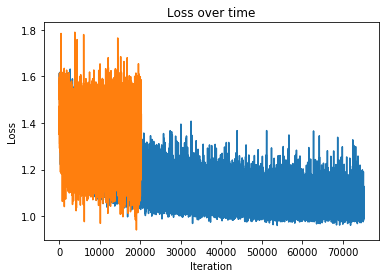

In [24]:
fig = plt.figure()
plt.title('Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(range(len(train_loss_history)), train_loss_history, label='Train Loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
# fig.savefig('Loss over time (5 classes).png')

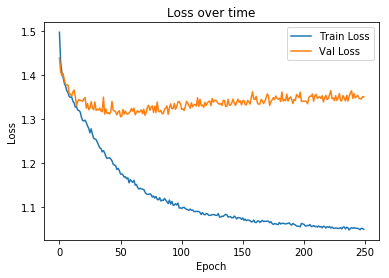

In [26]:
fig = plt.figure()
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(averaged_train_loss_hist)), averaged_train_loss_hist, label='Train Loss')
plt.plot(range(len(averaged_val_loss_history)), averaged_val_loss_history, label='Val Loss')
plt.legend()

In [ ]:
val_hist = np.asarray(val_iou_history)
train_hist = np.asarray(train_iou_history)
print(val_hist.shape)
print(train_hist.shape)

In [ ]:
fig = plt.figure()
plt.title('IOU for no tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,0], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,0], label='train')
plt.legend()
fig.savefig('IOU for no tumor (5 classes) - Poster.png')

In [ ]:
fig = plt.figure()
plt.title('IOU for tumor 1 over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,1], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,1], label='train')
plt.legend()
fig.savefig('IOU for tumor 1 (5 classes) - Poster.png')

In [ ]:
fig = plt.figure()
plt.title('IOU for tumor 2 over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,2], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,2], label='train')
plt.legend()
fig.savefig('IOU for tumor 2 (5 classes) - Poster.png')

In [ ]:
fig = plt.figure()
plt.title('IOU for tumor 4 over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,4], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,4], label='train')
plt.legend()
fig.savefig('IOU for tumor 4 (5 classes) - Poster.png')

In [ ]:
check_iou(test_loader, model)